# Train using balanced subsets of data - 224x224 Redux

### Findings
- Dataset has propensity for flucting validation loss, even with increated dropotuand reduced model layers
- Training at very low LR (1e4) gives more stable results, bult ultimately sub-optimal final results
- Better results achieved using higher LR, and using SaveModelCallback to capture local minima
- Combining multiple top learners gives significantly better results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import collections

In [3]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
import os
import pickle

import scipy
from scipy.stats import gmean, hmean

In [4]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, \
                          get_accuracy, analyze_confidence, accuracy_vs_threshold, \
                          show_incremental_accuracy,  analyze_low_confidence, \
                          plot_confusion_matrix_thresh, get_val_stats, model_cutter

In [5]:
#from pneumonia_loaders import *

In [6]:
from pneumonia_loaders import show_categories
from pneumonia_new_loader import get_db

In [7]:
from helpers import get_best_stats, show_results, show_results
from helpers import StatsRepo, stats_repo_unit_test
from helpers import _get_learner, _get_interp, analyze_interp, _do_train

# Config

In [8]:
model = models.resnet18
size=224
n_samples=1000    # total number of training samples

In [9]:
all_bs = {225:31, 448:31, 896:7}

In [10]:
data_base = Path()/'data'
model_base = Path('D:/Users/Doug/Models/chest_xray')

all_bs = {224:31, 448:31, 896:7}

In [11]:
prefix = f'18_{size}'
short_prefix = f'18_{size}'

data_subdir  = f'chest_xray_{size}'
model_subdir = f'18_{size}'

if size in [224, 448, 896]:
    path = data_base/data_subdir
    model_dir = (model_base/model_subdir).absolute()
    bs = all_bs[size]
else:
    raise Exception('Unknown size')

In [12]:
bs, model_dir

(31, WindowsPath('D:/Users/Doug/Models/chest_xray/18_224'))

In [13]:
path.ls()

[WindowsPath('data/chest_xray_224/test'),
 WindowsPath('data/chest_xray_224/train'),
 WindowsPath('data/chest_xray_224/val')]

# Code

In [14]:
def my_transforms():
    tfms = get_transforms(do_flip=True, flip_vert=False,
                          max_zoom=1.3, max_lighting=0.3)
    return tfms

In [15]:
def get_params(all_lr=[1e-2, 3e-3, 1e-3], all_cycles=[1,2,4, 8]):
    global short_prefix
    for lr in all_lr:
        for cycles in all_cycles:
            key = f'{short_prefix}_lr_{lr}_cyc_{cycles}'
            yield key, {'cycles':cycles, 'max_lr':lr}

In [16]:
def restore_learner(name, ps=0.5, compute_baseline=True):
    learn = get_learner(ps=ps)
    learn.load(name)
    
    if compute_baseline:
        base = learn.svalidate()
        base = {'loss': base[0], 'error_rate': float(base[1]), 'accuracy': float(base[2])}
    else:
        base = None
    return learn, base

def refine_learner(name, ps=0.8, lr=1e-6, cycles=16, **kwargs):
    learn, base = restore_learner(name, ps=ps)
    print('base:', base)
    learn.unfreeze()
    learn.fit_one_cycle(cycles, max_lr=slice(lr,lr),
                        callbacks=[SaveModelCallback(learn, every='improvement', 
                                   monitor='accuracy', name='best')], **kwargs)
    stats = get_best_stats(learn)
    
    if stats['error_rate'] < base['error_rate']:
        new_name = f'{name}_r_lr{lr}_c{cycles}_ps{ps}'
        print('keeping:', stats)
        return learn, stats, new_name
    else:
        print('ignoring:', stats)
        return None, None, None

# Additional Configuration

###### Initialize stats repo (use prior contents if available)

In [17]:
all_stats = StatsRepo(prefix, force_init=False, verbose=True)

restored stats from: stats\18_224_stats.p


###### Get Training/Validation/Test dataset for  Normal / Viral / Bacterial

In [18]:
#data = get_db_np(path, size=size, scale=10, tfms=my_transforms())
data, data_test = get_db(path, kind='nvb', n_samples=n_samples, scale=1, include_test=True,
                  size=size, bs=bs, tfms=my_transforms())
print('Training set:')
show_categories(data.train_ds.y)
print('\nValidation set:')
show_categories(data.valid_ds.y)
print('\nTest set:')
show_categories(data_test.valid_ds.y)

Training set:
  bacteria  :  1000     33.3%
  normal    :  1000     33.3%
  virus     :  1000     33.3%
  Total     :  3000

Validation set:
  bacteria  :    74     33.3%
  normal    :    74     33.3%
  virus     :    74     33.3%
  Total     :   222

Test set:
  bacteria  :    74     33.3%
  normal    :    74     33.3%
  virus     :    74     33.3%
  Total     :   222


In [19]:
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
virus,normal,normal,normal,bacteria
Path: data\chest_xray_224;

Valid: LabelList (222 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bacteria,virus,bacteria,virus,bacteria
Path: data\chest_xray_224;

Test: None

###### Define configuration specific functions and initialize stats repo (use prior contents if available)

In [20]:
get_learner = partial(_get_learner, db=data, model=model, model_dir=model_dir)
get_learner_test = partial(_get_learner, db=data_test, model=model, model_dir=model_dir)

get_interp = partial(_get_interp, get_learner=get_learner)
get_interp_test = partial(_get_interp, get_learner=get_learner_test)

do_train = partial(_do_train, get_learner=get_learner, stats_repo=all_stats)

In [21]:
import scipy
from scipy.stats import gmean, hmean

def compute_acc(preds, y_true):
    yy = np.argmax(preds, axis=-1)
    return np.mean(yy==y_true)
    

def combine_predictions(all_interp):
    y_true = to_np(all_interp[0][1].y_true)
    all_preds = np.stack([to_np(interp.preds) for _, interp in all_interp])
    
    preds = np.mean(all_preds, axis=0)
    acc_m = compute_acc(preds, y_true) 
    
    preds = np.median(all_preds, axis=0)
    acc_med = compute_acc(preds, y_true)
    
    preds = gmean(all_preds, axis=0)
    acc_g = compute_acc(preds, y_true)
    
    preds = hmean(all_preds, axis=0)
    acc_h = compute_acc(preds, y_true)
    
    print(f'accuracy -- mean: {acc_m:0.3f}   median: {acc_med:0.3f}   gmean: {acc_g:0.3f}   hmean: {acc_h:0.3f}')
    return acc_m, acc_med, acc_g, acc_h

## Various Development Tests
Disabled by default

# Analysis

In [22]:
# barrier after initialization for notebook restart
assert False

AssertionError: 

### Basic LR Finder runs

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07 
Min loss divided by 10: 2.75E-03
Min numerical gradient: 3.63E-03  (smoothed)
Min numerical gradient: 6.31E-03
Min loss divided by 10: 3.31E-03


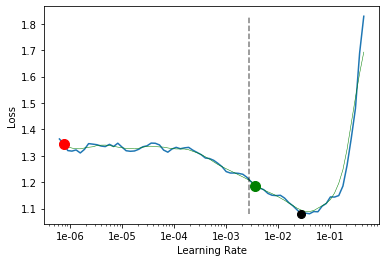

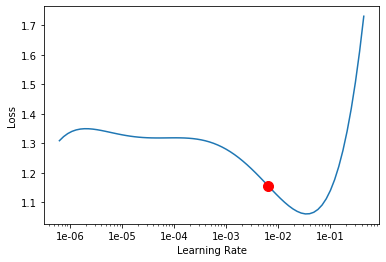

In [42]:
learn = get_learner()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

## Explore Baseline

18_224_lr_0.01_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.760007,0.525766,0.193694,0.806306,00:31


Better model found at epoch 0 with accuracy value: 0.8063063025474548.


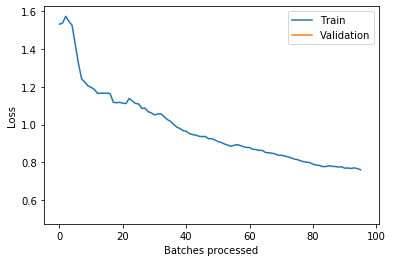

18_224_lr_0.01_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.801333,0.690759,0.270270,0.729730,00:30
1,0.621372,0.813712,0.243243,0.756757,00:30


Better model found at epoch 0 with accuracy value: 0.7297297120094299.
Better model found at epoch 1 with accuracy value: 0.7567567825317383.


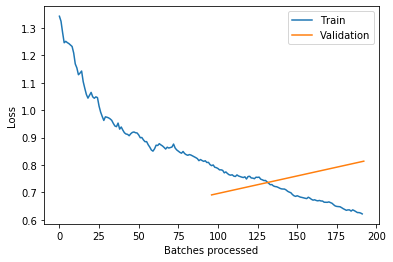

18_224_lr_0.01_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.804647,1.167787,0.450450,0.549550,00:31
1,0.687302,0.709259,0.238739,0.761261,00:30
2,0.576200,0.818989,0.252252,0.747748,00:30
3,0.501008,0.785650,0.211712,0.788288,00:31


Better model found at epoch 0 with accuracy value: 0.5495495200157166.
Better model found at epoch 1 with accuracy value: 0.7612612843513489.
Better model found at epoch 3 with accuracy value: 0.7882882952690125.


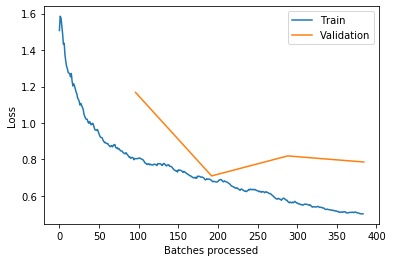

18_224_lr_0.01_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.821688,0.569867,0.180180,0.819820,00:31
1,0.700455,0.933316,0.351351,0.648649,00:31
2,0.667219,0.742712,0.283784,0.716216,00:30
3,0.608039,0.516003,0.148649,0.851351,00:31
4,0.560516,0.808521,0.256757,0.743243,00:31
5,0.516773,0.677735,0.198198,0.801802,00:30
6,0.474141,0.636521,0.180180,0.819820,00:31
7,0.456443,0.771157,0.211712,0.788288,00:30


Better model found at epoch 0 with accuracy value: 0.8198198080062866.
Better model found at epoch 3 with accuracy value: 0.8513513803482056.


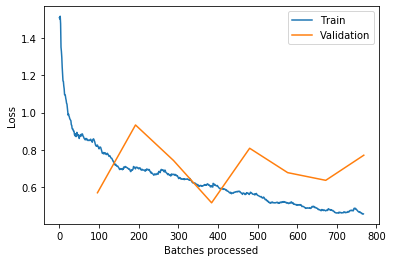

18_224_lr_0.003_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.797564,0.666195,0.234234,0.765766,00:32


Better model found at epoch 0 with accuracy value: 0.7657657861709595.


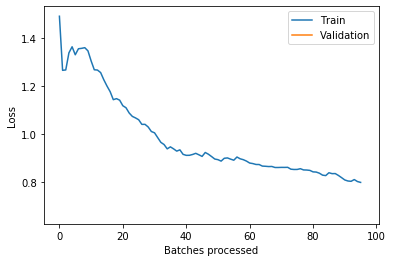

18_224_lr_0.003_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.796348,0.672698,0.252252,0.747748,00:31
1,0.650531,0.691843,0.247748,0.752252,00:31


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 1 with accuracy value: 0.7522522807121277.


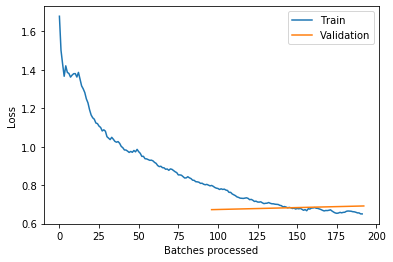

18_224_lr_0.003_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.863762,0.623393,0.243243,0.756757,00:30
1,0.686227,0.633917,0.220721,0.779279,00:31
2,0.590715,0.570305,0.157658,0.842342,00:30
3,0.534672,0.535517,0.166667,0.833333,00:31


Better model found at epoch 0 with accuracy value: 0.7567567825317383.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 2 with accuracy value: 0.8423423171043396.


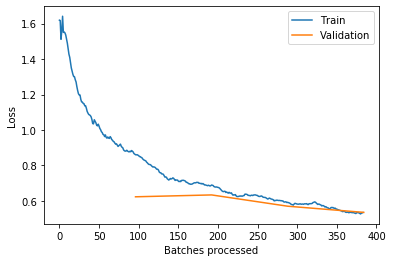

18_224_lr_0.003_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.839481,0.699190,0.207207,0.792793,00:31
1,0.722902,0.593582,0.189189,0.810811,00:31
2,0.620328,0.592405,0.180180,0.819820,00:30
3,0.597662,0.468976,0.157658,0.842342,00:30
4,0.519536,0.559369,0.175676,0.824324,00:31
5,0.500237,0.725714,0.220721,0.779279,00:30
6,0.462165,0.586497,0.184685,0.815315,00:30
7,0.464884,0.640231,0.189189,0.810811,00:30


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.
Better model found at epoch 2 with accuracy value: 0.8198198080062866.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.


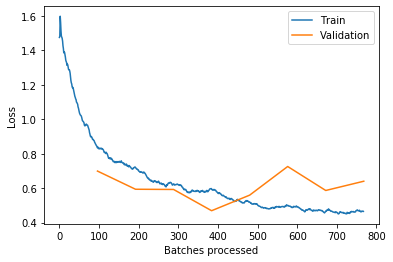

18_224_lr_0.001_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.834413,0.610575,0.175676,0.824324,00:30


Better model found at epoch 0 with accuracy value: 0.8243243098258972.


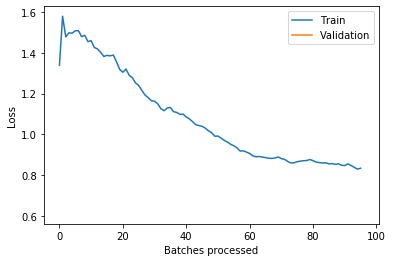

18_224_lr_0.001_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.911355,0.595071,0.216216,0.783784,00:30
1,0.732517,0.626282,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.7837837934494019.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.


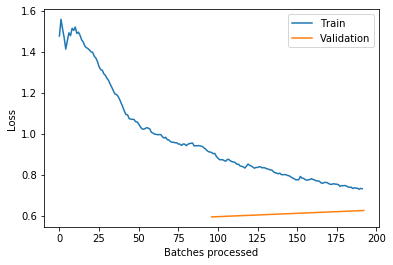

18_224_lr_0.001_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.952303,0.677713,0.229730,0.770270,00:31
1,0.742297,0.660860,0.207207,0.792793,00:31
2,0.676268,0.590257,0.184685,0.815315,00:31
3,0.631775,0.586785,0.193694,0.806306,00:31


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 1 with accuracy value: 0.792792797088623.
Better model found at epoch 2 with accuracy value: 0.815315306186676.


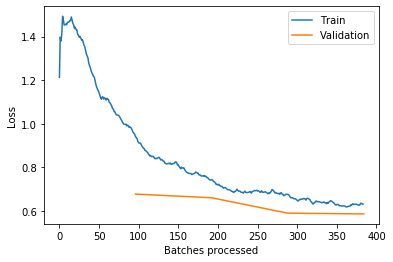

18_224_lr_0.001_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.030097,0.679513,0.238739,0.761261,00:30
1,0.789384,0.688297,0.225225,0.774775,00:30
2,0.693596,0.667003,0.225225,0.774775,00:30
3,0.644195,0.567098,0.175676,0.824324,00:30
4,0.572053,0.524754,0.135135,0.864865,00:31
5,0.543915,0.579939,0.171171,0.828829,00:31
6,0.523033,0.565184,0.157658,0.842342,00:30
7,0.518396,0.581297,0.175676,0.824324,00:31


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.
Better model found at epoch 3 with accuracy value: 0.8243243098258972.
Better model found at epoch 4 with accuracy value: 0.8648648858070374.


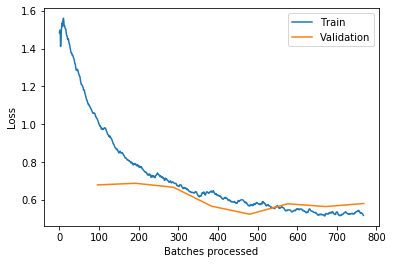

saved stats to: stats\18_224_stats.p


In [45]:
for key, params in get_params():
    do_train(key, **params)
all_stats.save()

18_224_lr_0.0003_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.974640,0.677426,0.274775,0.725225,00:30


Better model found at epoch 0 with accuracy value: 0.7252252101898193.


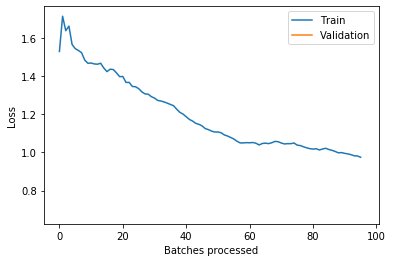

18_224_lr_0.0003_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.988371,0.643569,0.256757,0.743243,00:31
1,0.816110,0.625457,0.220721,0.779279,00:31


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.


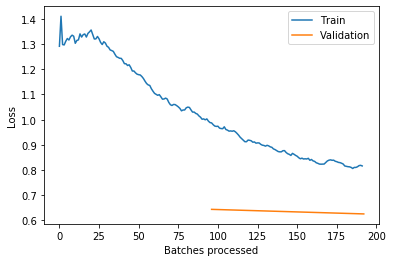

18_224_lr_0.0003_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.120514,0.639763,0.238739,0.761261,00:30
1,0.853344,0.601680,0.202703,0.797297,00:31
2,0.766705,0.599528,0.184685,0.815315,00:30
3,0.745972,0.610290,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.7612612843513489.
Better model found at epoch 1 with accuracy value: 0.7972972989082336.
Better model found at epoch 2 with accuracy value: 0.815315306186676.


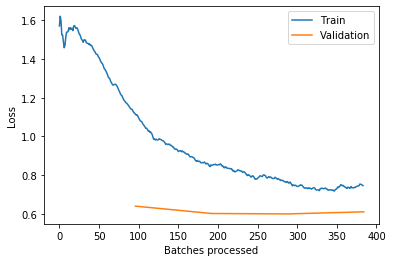

18_224_lr_0.0003_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.272617,0.788402,0.333333,0.666667,00:31
1,0.933969,0.608226,0.211712,0.788288,00:31
2,0.776082,0.611654,0.184685,0.815315,00:30
3,0.702367,0.621290,0.211712,0.788288,00:30
4,0.704630,0.619722,0.202703,0.797297,00:32
5,0.647417,0.596013,0.180180,0.819820,00:31
6,0.645209,0.598602,0.193694,0.806306,00:31
7,0.639918,0.606465,0.193694,0.806306,00:31


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 1 with accuracy value: 0.7882882952690125.
Better model found at epoch 2 with accuracy value: 0.815315306186676.
Better model found at epoch 5 with accuracy value: 0.8198198080062866.


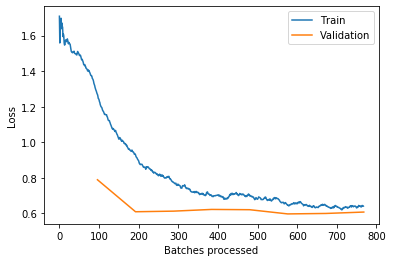

18_224_lr_0.0001_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.149811,0.810769,0.315315,0.684685,00:30


Better model found at epoch 0 with accuracy value: 0.684684693813324.


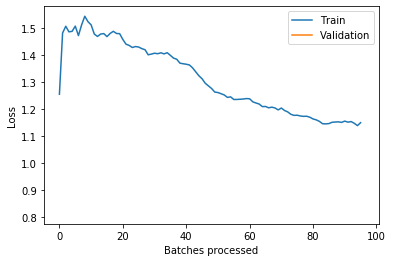

18_224_lr_0.0001_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.048926,0.718260,0.265766,0.734234,00:31
1,0.907254,0.684232,0.234234,0.765766,00:31


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 1 with accuracy value: 0.7657657861709595.


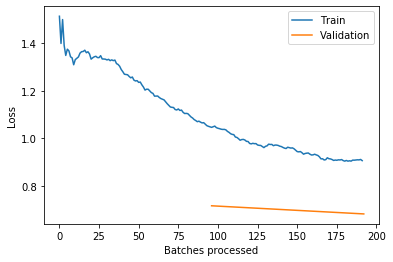

18_224_lr_0.0001_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.191485,0.863982,0.382883,0.617117,00:30
1,0.953096,0.687588,0.229730,0.770270,00:30
2,0.832414,0.654436,0.225225,0.774775,00:30
3,0.835077,0.655815,0.216216,0.783784,00:31


Better model found at epoch 0 with accuracy value: 0.6171171069145203.
Better model found at epoch 1 with accuracy value: 0.7702702879905701.
Better model found at epoch 2 with accuracy value: 0.7747747898101807.
Better model found at epoch 3 with accuracy value: 0.7837837934494019.


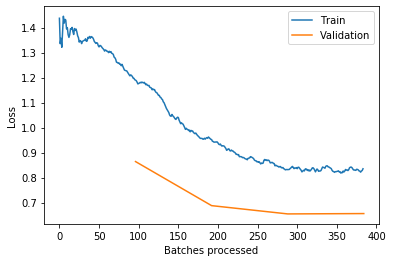

18_224_lr_0.0001_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.394086,1.057661,0.585586,0.414414,00:30
1,1.070442,0.720053,0.274775,0.725225,00:31
2,0.902095,0.646234,0.225225,0.774775,00:30
3,0.816352,0.617601,0.193694,0.806306,00:30
4,0.758370,0.613771,0.207207,0.792793,00:30
5,0.771951,0.600281,0.189189,0.810811,00:30
6,0.731244,0.637234,0.211712,0.788288,00:30
7,0.760237,0.602216,0.202703,0.797297,00:30


Better model found at epoch 0 with accuracy value: 0.4144144058227539.
Better model found at epoch 1 with accuracy value: 0.7252252101898193.
Better model found at epoch 2 with accuracy value: 0.7747747898101807.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.
Better model found at epoch 5 with accuracy value: 0.8108108043670654.


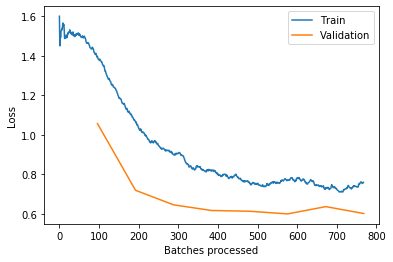

saved stats to: stats\18_224_stats.p


In [46]:
for key, params in get_params(all_lr=[3e-4, 1e-4]):
    do_train(key, **params)
all_stats.save()

In [47]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.135  med: 0.191   Loss -- best: 0.469  med: 0.618

18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_8  error_rate: 0.149   accuracy: 0.851   loss:0.5160
18_224_lr_0.003_cyc_4  error_rate: 0.158   accuracy: 0.842   loss:0.5703
18_224_lr_0.003_cyc_8  error_rate: 0.158   accuracy: 0.842   loss:0.4690
18_224_lr_0.001_cyc_1  error_rate: 0.176   accuracy: 0.824   loss:0.6106
18_224_lr_0.0003_cyc_8  error_rate: 0.180   accuracy: 0.820   loss:0.5960
18_224_lr_0.001_cyc_4  error_rate: 0.185   accuracy: 0.815   loss:0.5903
18_224_lr_0.0003_cyc_4  error_rate: 0.185   accuracy: 0.815   loss:0.5995
18_224_lr_0.0001_cyc_8  error_rate: 0.189   accuracy: 0.811   loss:0.6003
18_224_lr_0.001_cyc_2  error_rate: 0.189   accuracy: 0.811   loss:0.6263


18_224_lr_0.03_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.880368,0.636089,0.247748,0.752252,00:31


Better model found at epoch 0 with accuracy value: 0.7522522807121277.


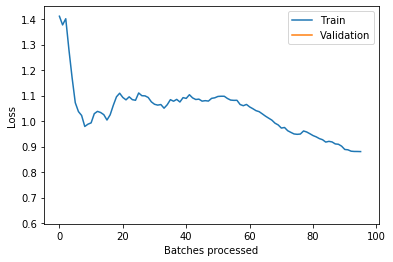

18_224_lr_0.03_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.972775,0.925374,0.432432,0.567568,00:30
1,0.673699,0.577890,0.166667,0.833333,00:31


Better model found at epoch 0 with accuracy value: 0.5675675272941589.
Better model found at epoch 1 with accuracy value: 0.8333333134651184.


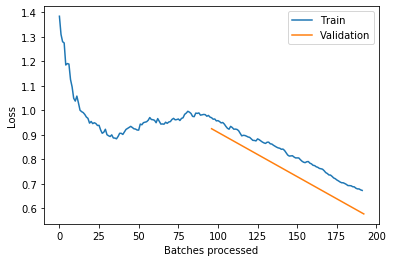

18_224_lr_0.03_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.843756,0.884511,0.409910,0.590090,00:31
1,0.822255,0.824837,0.297297,0.702703,00:30
2,0.624618,0.870433,0.243243,0.756757,00:30
3,0.534267,0.726359,0.238739,0.761261,00:31


Better model found at epoch 0 with accuracy value: 0.5900900959968567.
Better model found at epoch 1 with accuracy value: 0.7027027010917664.
Better model found at epoch 2 with accuracy value: 0.7567567825317383.
Better model found at epoch 3 with accuracy value: 0.7612612843513489.


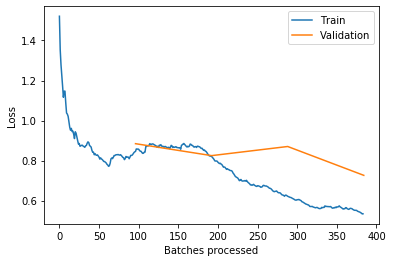

18_224_lr_0.03_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.749934,0.737334,0.234234,0.765766,00:30
1,0.825819,0.639371,0.234234,0.765766,00:31
2,0.704372,1.221847,0.418919,0.581081,00:30
3,0.657626,0.564526,0.202703,0.797297,00:30
4,0.640510,0.502053,0.198198,0.801802,00:31
5,0.552301,0.813899,0.283784,0.716216,00:30
6,0.531507,0.757183,0.243243,0.756757,00:30
7,0.476146,0.673358,0.193694,0.806306,00:30


Better model found at epoch 0 with accuracy value: 0.7657657861709595.
Better model found at epoch 3 with accuracy value: 0.7972972989082336.
Better model found at epoch 4 with accuracy value: 0.8018018007278442.
Better model found at epoch 7 with accuracy value: 0.8063063025474548.


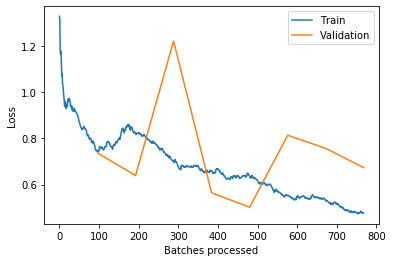

18_224_lr_0.1_cyc_1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.570027,0.823005,0.301802,0.698198,00:31


Better model found at epoch 0 with accuracy value: 0.6981981992721558.


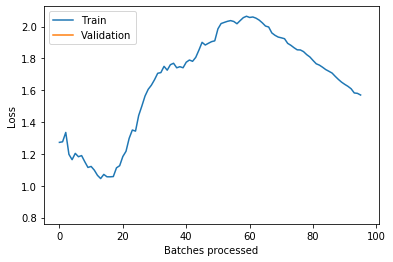

18_224_lr_0.1_cyc_2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.797090,2.385677,0.509009,0.490991,00:30
1,0.996215,0.605997,0.238739,0.761261,00:30


Better model found at epoch 0 with accuracy value: 0.4909909963607788.
Better model found at epoch 1 with accuracy value: 0.7612612843513489.


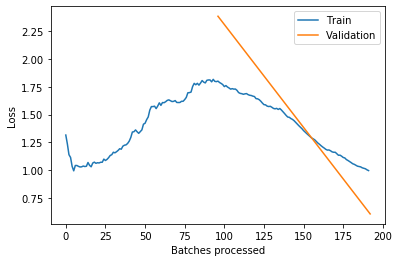

18_224_lr_0.1_cyc_4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.487517,10.227920,0.608108,0.391892,00:31
1,1.320321,0.615339,0.256757,0.743243,00:30
2,0.834387,0.579625,0.148649,0.851351,00:30
3,0.664011,0.592136,0.144144,0.855856,00:30


Better model found at epoch 0 with accuracy value: 0.3918918967247009.
Better model found at epoch 1 with accuracy value: 0.7432432174682617.
Better model found at epoch 2 with accuracy value: 0.8513513803482056.
Better model found at epoch 3 with accuracy value: 0.8558558821678162.


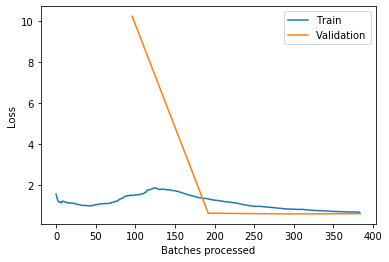

18_224_lr_0.1_cyc_8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.918424,1.624096,0.436937,0.563063,00:30
1,1.344635,9.090235,0.477478,0.522523,00:30
2,1.681383,2.545611,0.599099,0.400901,00:30
3,1.068370,0.866864,0.333333,0.666667,00:31
4,0.903092,0.634239,0.229730,0.770270,00:31
5,0.800341,0.804871,0.207207,0.792793,00:30
6,0.652687,0.665214,0.198198,0.801802,00:30
7,0.577687,0.517193,0.148649,0.851351,00:31


Better model found at epoch 0 with accuracy value: 0.5630630850791931.
Better model found at epoch 3 with accuracy value: 0.6666666865348816.
Better model found at epoch 4 with accuracy value: 0.7702702879905701.
Better model found at epoch 5 with accuracy value: 0.792792797088623.
Better model found at epoch 6 with accuracy value: 0.8018018007278442.
Better model found at epoch 7 with accuracy value: 0.8513513803482056.


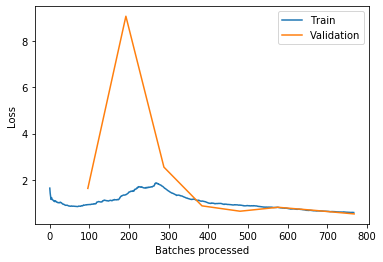

saved stats to: stats\18_224_stats.p


In [48]:
for key, params in get_params(all_lr=[3e-2, 1e-1]):
    do_train(key, **params)
all_stats.save()

In [49]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.135  med: 0.194   Loss -- best: 0.469  med: 0.618

18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.1_cyc_4   error_rate: 0.144   accuracy: 0.856   loss:0.5921
18_224_lr_0.01_cyc_8  error_rate: 0.149   accuracy: 0.851   loss:0.5160
18_224_lr_0.1_cyc_8   error_rate: 0.149   accuracy: 0.851   loss:0.5172
18_224_lr_0.003_cyc_4  error_rate: 0.158   accuracy: 0.842   loss:0.5703
18_224_lr_0.003_cyc_8  error_rate: 0.158   accuracy: 0.842   loss:0.4690
18_224_lr_0.03_cyc_2  error_rate: 0.167   accuracy: 0.833   loss:0.5779
18_224_lr_0.001_cyc_1  error_rate: 0.176   accuracy: 0.824   loss:0.6106
18_224_lr_0.0003_cyc_8  error_rate: 0.180   accuracy: 0.820   loss:0.5960
18_224_lr_0.001_cyc_4  error_rate: 0.185   accuracy: 0.815   loss:0.5903


18_224_lr_0.001_cyc_16_ps_0.5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.174571,0.769329,0.292793,0.707207,00:31
1,0.857337,0.621328,0.216216,0.783784,00:31
2,0.765663,0.590793,0.193694,0.806306,00:30
3,0.681484,0.636563,0.207207,0.792793,00:31
4,0.645027,0.528699,0.166667,0.833333,00:31
5,0.602346,0.634515,0.198198,0.801802,00:31
6,0.574430,0.588396,0.198198,0.801802,00:31
7,0.534816,0.593018,0.180180,0.819820,00:31
8,0.509992,0.557186,0.175676,0.824324,00:31
9,0.492346,0.657889,0.198198,0.801802,00:30


Better model found at epoch 0 with accuracy value: 0.707207202911377.
Better model found at epoch 1 with accuracy value: 0.7837837934494019.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 4 with accuracy value: 0.8333333134651184.


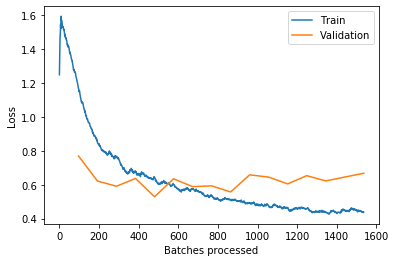

18_224_lr_0.001_cyc_16_ps_0.8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.697761,0.874321,0.364865,0.635135,00:30
1,1.285397,0.644864,0.198198,0.801802,00:30
2,1.048361,0.624145,0.189189,0.810811,00:30
3,0.838413,0.585021,0.171171,0.828829,00:31
4,0.707673,0.514165,0.153153,0.846847,00:30
5,0.662485,0.511548,0.144144,0.855856,00:31
6,0.614438,0.508178,0.139640,0.860360,00:31
7,0.600864,0.536062,0.162162,0.837838,00:31
8,0.570535,0.537156,0.157658,0.842342,00:30
9,0.542122,0.558122,0.180180,0.819820,00:31


Better model found at epoch 0 with accuracy value: 0.6351351141929626.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 2 with accuracy value: 0.8108108043670654.
Better model found at epoch 3 with accuracy value: 0.8288288116455078.
Better model found at epoch 4 with accuracy value: 0.8468468189239502.
Better model found at epoch 5 with accuracy value: 0.8558558821678162.
Better model found at epoch 6 with accuracy value: 0.8603603839874268.


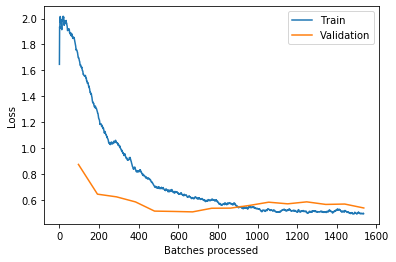

18_224_lr_0.001_cyc_16_ps_0.85


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.865755,0.928263,0.414414,0.585586,00:30
1,1.401689,0.687663,0.225225,0.774775,00:31
2,1.181314,0.652934,0.207207,0.792793,00:31
3,0.965265,0.587754,0.162162,0.837838,00:31
4,0.829552,0.587667,0.175676,0.824324,00:31
5,0.698933,0.559627,0.162162,0.837838,00:30
6,0.651621,0.627300,0.207207,0.792793,00:31
7,0.606091,0.601577,0.207207,0.792793,00:31
8,0.596077,0.580931,0.162162,0.837838,00:31
9,0.576109,0.650801,0.198198,0.801802,00:30


Better model found at epoch 0 with accuracy value: 0.5855855941772461.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.792792797088623.
Better model found at epoch 3 with accuracy value: 0.837837815284729.
Better model found at epoch 12 with accuracy value: 0.8423423171043396.


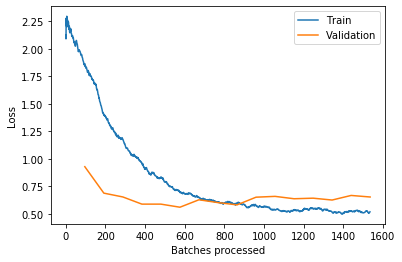

18_224_lr_0.001_cyc_16_ps_0.9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.182312,0.966932,0.459459,0.540541,00:31
1,1.870115,0.698162,0.261261,0.738739,00:31
2,1.431506,0.674686,0.211712,0.788288,00:30
3,1.105680,0.678054,0.202703,0.797297,00:30
4,0.867409,0.660440,0.189189,0.810811,00:30
5,0.755934,0.628440,0.166667,0.833333,00:30
6,0.700211,0.611798,0.175676,0.824324,00:31
7,0.663282,0.607071,0.171171,0.828829,00:30
8,0.610563,0.627719,0.193694,0.806306,00:30
9,0.594766,0.583888,0.175676,0.824324,00:30


Better model found at epoch 0 with accuracy value: 0.5405405163764954.
Better model found at epoch 1 with accuracy value: 0.7387387156486511.
Better model found at epoch 2 with accuracy value: 0.7882882952690125.
Better model found at epoch 3 with accuracy value: 0.7972972989082336.
Better model found at epoch 4 with accuracy value: 0.8108108043670654.
Better model found at epoch 5 with accuracy value: 0.8333333134651184.
Better model found at epoch 10 with accuracy value: 0.837837815284729.
Better model found at epoch 13 with accuracy value: 0.8423423171043396.


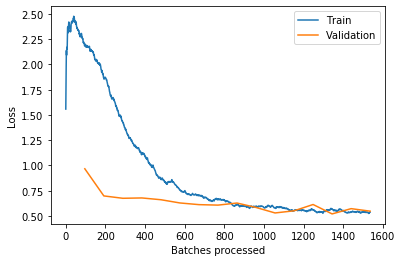

18_224_lr_0.0003_cyc_16_ps_0.5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.271077,0.943760,0.481982,0.518018,00:31
1,1.032680,0.675856,0.252252,0.747748,00:31
2,0.857880,0.613661,0.202703,0.797297,00:31
3,0.789739,0.601683,0.193694,0.806306,00:30
4,0.721710,0.595123,0.180180,0.819820,00:30
5,0.677123,0.583569,0.184685,0.815315,00:30
6,0.628815,0.544436,0.189189,0.810811,00:30
7,0.622659,0.563805,0.202703,0.797297,00:31
8,0.626062,0.614688,0.216216,0.783784,00:30
9,0.606321,0.538458,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.5180180072784424.
Better model found at epoch 1 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.
Better model found at epoch 4 with accuracy value: 0.8198198080062866.
Better model found at epoch 10 with accuracy value: 0.8333333134651184.
Better model found at epoch 12 with accuracy value: 0.837837815284729.


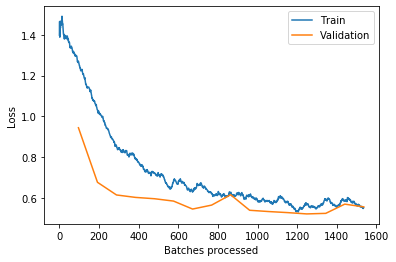

18_224_lr_0.0003_cyc_16_ps_0.8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.736795,0.967815,0.468468,0.531532,00:31
1,1.515326,0.725705,0.252252,0.747748,00:30
2,1.235712,0.638148,0.220721,0.779279,00:31
3,1.089583,0.639335,0.184685,0.815315,00:30
4,0.969774,0.639634,0.189189,0.810811,00:30
5,0.892201,0.620041,0.171171,0.828829,00:30
6,0.824587,0.591052,0.162162,0.837838,00:31
7,0.783691,0.577542,0.148649,0.851351,00:30
8,0.742260,0.607773,0.166667,0.833333,00:31
9,0.696779,0.602729,0.166667,0.833333,00:30


Better model found at epoch 0 with accuracy value: 0.5315315127372742.
Better model found at epoch 1 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.7792792916297913.
Better model found at epoch 3 with accuracy value: 0.815315306186676.
Better model found at epoch 5 with accuracy value: 0.8288288116455078.
Better model found at epoch 6 with accuracy value: 0.837837815284729.
Better model found at epoch 7 with accuracy value: 0.8513513803482056.


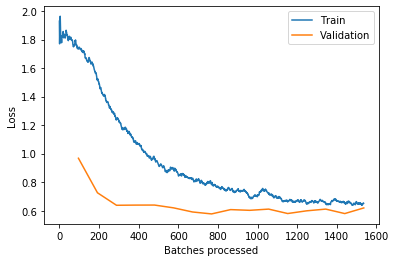

18_224_lr_0.0003_cyc_16_ps_0.85


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.986065,1.058076,0.522523,0.477477,00:31
1,1.786305,0.806805,0.324324,0.675676,00:31
2,1.495802,0.693431,0.247748,0.752252,00:31
3,1.264176,0.676672,0.225225,0.774775,00:31
4,1.037515,0.655211,0.211712,0.788288,00:31
5,1.008617,0.620067,0.193694,0.806306,00:31
6,0.945658,0.594770,0.171171,0.828829,00:31
7,0.865118,0.610652,0.184685,0.815315,00:30
8,0.787490,0.600176,0.171171,0.828829,00:31
9,0.767159,0.608250,0.180180,0.819820,00:31


Better model found at epoch 0 with accuracy value: 0.477477490901947.
Better model found at epoch 1 with accuracy value: 0.6756756901741028.
Better model found at epoch 2 with accuracy value: 0.7522522807121277.
Better model found at epoch 3 with accuracy value: 0.7747747898101807.
Better model found at epoch 4 with accuracy value: 0.7882882952690125.
Better model found at epoch 5 with accuracy value: 0.8063063025474548.
Better model found at epoch 6 with accuracy value: 0.8288288116455078.
Better model found at epoch 13 with accuracy value: 0.8333333134651184.


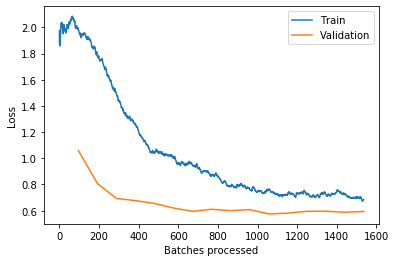

18_224_lr_0.0003_cyc_16_ps_0.9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.438348,1.136782,0.576577,0.423423,00:31
1,2.151670,0.839935,0.333333,0.666667,00:31
2,1.837584,0.660026,0.229730,0.770270,00:30
3,1.466936,0.650861,0.193694,0.806306,00:31
4,1.351729,0.653277,0.198198,0.801802,00:30
5,1.206630,0.652323,0.202703,0.797297,00:31
6,1.012120,0.637011,0.198198,0.801802,00:31
7,0.919436,0.615021,0.184685,0.815315,00:30
8,0.887766,0.580773,0.175676,0.824324,00:31
9,0.832319,0.585604,0.171171,0.828829,00:30


Better model found at epoch 0 with accuracy value: 0.4234234094619751.
Better model found at epoch 1 with accuracy value: 0.6666666865348816.
Better model found at epoch 2 with accuracy value: 0.7702702879905701.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.
Better model found at epoch 7 with accuracy value: 0.815315306186676.
Better model found at epoch 8 with accuracy value: 0.8243243098258972.
Better model found at epoch 9 with accuracy value: 0.8288288116455078.


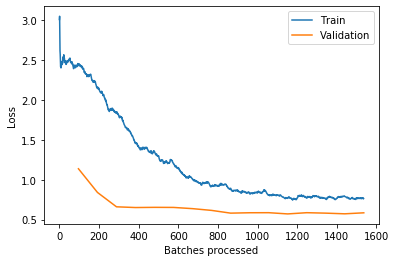

18_224_lr_0.0001_cyc_16_ps_0.5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.329631,1.055835,0.531532,0.468468,00:31
1,1.153850,0.832994,0.369369,0.630631,00:30
2,0.998166,0.702907,0.261261,0.738739,00:30
3,0.882700,0.671524,0.220721,0.779279,00:31
4,0.809092,0.673809,0.220721,0.779279,00:30
5,0.769072,0.658056,0.211712,0.788288,00:30
6,0.745969,0.650470,0.207207,0.792793,00:30
7,0.724154,0.659639,0.216216,0.783784,00:31
8,0.683325,0.623103,0.198198,0.801802,00:30
9,0.662678,0.628892,0.198198,0.801802,00:31


Better model found at epoch 0 with accuracy value: 0.46846845746040344.
Better model found at epoch 1 with accuracy value: 0.630630612373352.
Better model found at epoch 2 with accuracy value: 0.7387387156486511.
Better model found at epoch 3 with accuracy value: 0.7792792916297913.
Better model found at epoch 5 with accuracy value: 0.7882882952690125.
Better model found at epoch 6 with accuracy value: 0.792792797088623.
Better model found at epoch 8 with accuracy value: 0.8018018007278442.


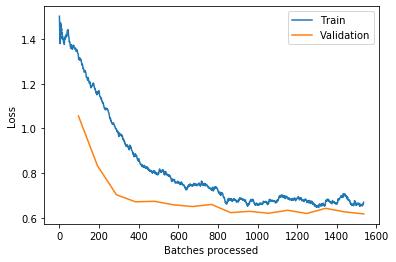

18_224_lr_0.0001_cyc_16_ps_0.8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.836170,1.026269,0.500000,0.500000,00:30
1,1.715417,0.886470,0.391892,0.608108,00:31
2,1.513955,0.708457,0.279279,0.720721,00:31
3,1.305463,0.633408,0.234234,0.765766,00:30
4,1.163158,0.611316,0.216216,0.783784,00:30
5,1.128014,0.609749,0.193694,0.806306,00:31
6,1.057106,0.608489,0.189189,0.810811,00:30
7,1.000322,0.605840,0.180180,0.819820,00:31
8,0.943696,0.594711,0.184685,0.815315,00:30
9,0.957930,0.599068,0.175676,0.824324,00:30


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.6081081032752991.
Better model found at epoch 2 with accuracy value: 0.7207207083702087.
Better model found at epoch 3 with accuracy value: 0.7657657861709595.
Better model found at epoch 4 with accuracy value: 0.7837837934494019.
Better model found at epoch 5 with accuracy value: 0.8063063025474548.
Better model found at epoch 6 with accuracy value: 0.8108108043670654.
Better model found at epoch 7 with accuracy value: 0.8198198080062866.
Better model found at epoch 9 with accuracy value: 0.8243243098258972.
Better model found at epoch 10 with accuracy value: 0.8288288116455078.
Better model found at epoch 11 with accuracy value: 0.8333333134651184.
Better model found at epoch 13 with accuracy value: 0.837837815284729.


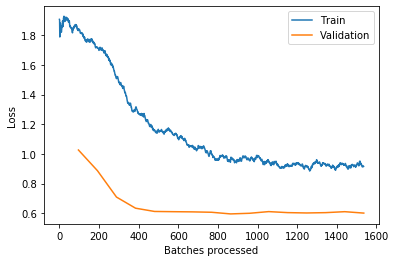

18_224_lr_0.0001_cyc_16_ps_0.85


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.022920,1.174042,0.626126,0.373874,00:30
1,1.947032,1.041014,0.522523,0.477477,00:30
2,1.744725,0.849134,0.409910,0.590090,00:31
3,1.567943,0.740622,0.279279,0.720721,00:31
4,1.369283,0.685558,0.243243,0.756757,00:30
5,1.288757,0.672644,0.229730,0.770270,00:30
6,1.209956,0.650973,0.216216,0.783784,00:30
7,1.105098,0.649987,0.207207,0.792793,00:31
8,1.106996,0.641120,0.198198,0.801802,00:31
9,1.051618,0.645054,0.211712,0.788288,00:31


Better model found at epoch 0 with accuracy value: 0.37387385964393616.
Better model found at epoch 1 with accuracy value: 0.477477490901947.
Better model found at epoch 2 with accuracy value: 0.5900900959968567.
Better model found at epoch 3 with accuracy value: 0.7207207083702087.
Better model found at epoch 4 with accuracy value: 0.7567567825317383.
Better model found at epoch 5 with accuracy value: 0.7702702879905701.
Better model found at epoch 6 with accuracy value: 0.7837837934494019.
Better model found at epoch 7 with accuracy value: 0.792792797088623.
Better model found at epoch 8 with accuracy value: 0.8018018007278442.
Better model found at epoch 11 with accuracy value: 0.8063063025474548.
Better model found at epoch 12 with accuracy value: 0.815315306186676.


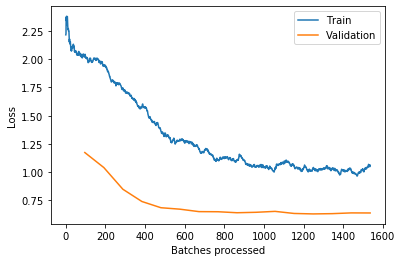

18_224_lr_0.0001_cyc_16_ps_0.9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.424708,1.142719,0.585586,0.414414,00:30
1,2.328550,1.034221,0.486487,0.513514,00:30
2,2.180399,0.874641,0.378378,0.621622,00:31
3,1.961511,0.776995,0.301802,0.698198,00:31
4,1.720421,0.726958,0.261261,0.738739,00:31
5,1.564967,0.708804,0.238739,0.761261,00:31
6,1.417311,0.697109,0.229730,0.770270,00:30
7,1.366178,0.697087,0.220721,0.779279,00:31
8,1.313025,0.697515,0.225225,0.774775,00:31
9,1.301721,0.691317,0.207207,0.792793,00:30


Better model found at epoch 0 with accuracy value: 0.4144144058227539.
Better model found at epoch 1 with accuracy value: 0.5135135054588318.
Better model found at epoch 2 with accuracy value: 0.6216216087341309.
Better model found at epoch 3 with accuracy value: 0.6981981992721558.
Better model found at epoch 4 with accuracy value: 0.7387387156486511.
Better model found at epoch 5 with accuracy value: 0.7612612843513489.
Better model found at epoch 6 with accuracy value: 0.7702702879905701.
Better model found at epoch 7 with accuracy value: 0.7792792916297913.
Better model found at epoch 9 with accuracy value: 0.792792797088623.
Better model found at epoch 10 with accuracy value: 0.7972972989082336.
Better model found at epoch 11 with accuracy value: 0.8018018007278442.


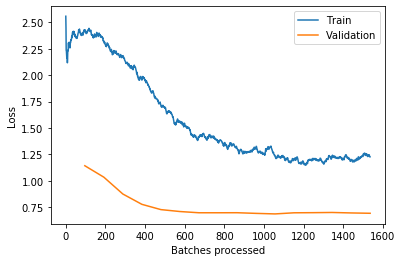

saved stats to: stats\18_224_stats.p


In [50]:
for key, params in get_params(all_cycles=[16], all_lr=[1e-3, 3e-4, 1e-4]):
    for ps in [0.5, 0.8, 0.85, 0.9]:
        do_train(key, ps=ps, **params)
all_stats.save()

In [51]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.135  med: 0.185   Loss -- best: 0.469  med: 0.605

18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.140   accuracy: 0.860   loss:0.5082
18_224_lr_0.1_cyc_4   error_rate: 0.144   accuracy: 0.856   loss:0.5921
18_224_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.149   accuracy: 0.851   loss:0.5775
18_224_lr_0.01_cyc_8  error_rate: 0.149   accuracy: 0.851   loss:0.5160
18_224_lr_0.1_cyc_8   error_rate: 0.149   accuracy: 0.851   loss:0.5172
18_224_lr_0.003_cyc_4  error_rate: 0.158   accuracy: 0.842   loss:0.5703
18_224_lr_0.003_cyc_8  error_rate: 0.158   accuracy: 0.842   loss:0.4690
18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.158   accuracy: 0.842   loss:0.6418
18_224_lr_0.001_cyc_16_ps_0.9  error_rate: 0.158   accuracy: 0.842   loss:0.5199


### Focus on specific configurations

18_224cut_lr_0.01_cyc_8

18_224_lr_0.01_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.800055,0.713085,0.225225,0.774775,00:31
1,0.679901,0.674203,0.220721,0.779279,00:30
2,0.662589,0.842684,0.319820,0.680180,00:31
3,0.605340,0.545525,0.153153,0.846847,00:30
4,0.543998,0.744329,0.234234,0.765766,00:30
5,0.518443,0.919733,0.288288,0.711712,00:31
6,0.484622,0.703330,0.234234,0.765766,00:30
7,0.452672,0.707378,0.229730,0.770270,00:31


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 3 with accuracy value: 0.8468468189239502.


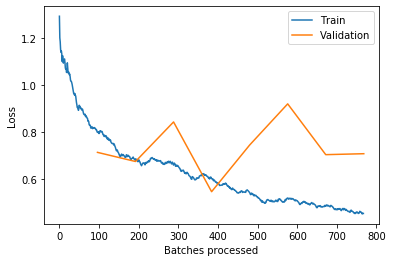

18_224_lr_0.01_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.799249,0.806051,0.252252,0.747748,00:30
1,0.685939,0.626460,0.211712,0.788288,00:31
2,0.665212,0.560781,0.193694,0.806306,00:31
3,0.634025,0.827366,0.310811,0.689189,00:30
4,0.568354,0.985032,0.328829,0.671171,00:31
5,0.522456,0.720736,0.279279,0.720721,00:31
6,0.473270,0.592531,0.175676,0.824324,00:30
7,0.455025,0.612584,0.180180,0.819820,00:30


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 1 with accuracy value: 0.7882882952690125.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 6 with accuracy value: 0.8243243098258972.


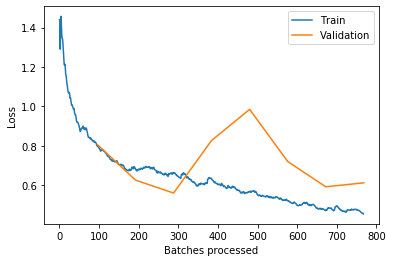

18_224_lr_0.01_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.812769,0.736764,0.310811,0.689189,00:30
1,0.692741,1.187328,0.432432,0.567568,00:30
2,0.663750,0.928213,0.360360,0.639640,00:30
3,0.598771,0.534070,0.198198,0.801802,00:30
4,0.551041,1.209285,0.382883,0.617117,00:30
5,0.526026,0.886906,0.288288,0.711712,00:31
6,0.470606,0.696162,0.211712,0.788288,00:30
7,0.466976,0.737816,0.238739,0.761261,00:30


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 3 with accuracy value: 0.8018018007278442.


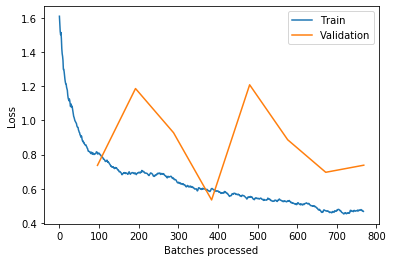

18_224_lr_0.01_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.860742,0.883591,0.297297,0.702703,00:31
1,0.693727,0.583455,0.180180,0.819820,00:30
2,0.648102,0.575444,0.198198,0.801802,00:30
3,0.621050,0.781436,0.310811,0.689189,00:31
4,0.573124,0.814359,0.256757,0.743243,00:30
5,0.525284,0.574053,0.175676,0.824324,00:30
6,0.476033,0.754542,0.225225,0.774775,00:30
7,0.455604,0.722496,0.207207,0.792793,00:31


Better model found at epoch 0 with accuracy value: 0.7027027010917664.
Better model found at epoch 1 with accuracy value: 0.8198198080062866.
Better model found at epoch 5 with accuracy value: 0.8243243098258972.


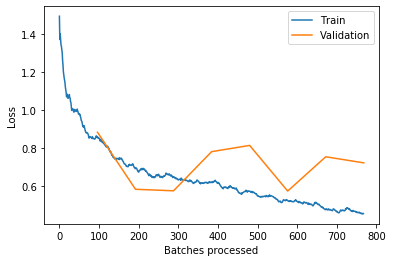

18_224_lr_0.01_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.802287,0.638732,0.211712,0.788288,00:30
1,0.692402,0.599846,0.198198,0.801802,00:30
2,0.641445,0.578794,0.193694,0.806306,00:30
3,0.615268,1.190794,0.391892,0.608108,00:30
4,0.545031,0.489768,0.121622,0.878378,00:31
5,0.521175,0.720405,0.202703,0.797297,00:30
6,0.467512,0.602042,0.193694,0.806306,00:30
7,0.455888,0.711161,0.229730,0.770270,00:30


Better model found at epoch 0 with accuracy value: 0.7882882952690125.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 4 with accuracy value: 0.8783783912658691.


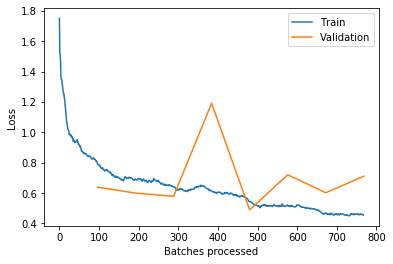

18_224_lr_0.01_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.792786,0.657458,0.229730,0.770270,00:30
1,0.683764,0.569425,0.193694,0.806306,00:30
2,0.642155,0.854178,0.279279,0.720721,00:31
3,0.597464,0.728864,0.216216,0.783784,00:30
4,0.534579,0.584964,0.157658,0.842342,00:31
5,0.523730,0.610512,0.202703,0.797297,00:30
6,0.468635,0.743666,0.220721,0.779279,00:30
7,0.440868,0.660534,0.211712,0.788288,00:31


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 1 with accuracy value: 0.8063063025474548.
Better model found at epoch 4 with accuracy value: 0.8423423171043396.


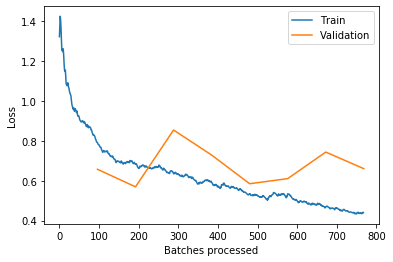

18_224_lr_0.01_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.814717,0.760707,0.243243,0.756757,00:31
1,0.694450,0.790040,0.256757,0.743243,00:30
2,0.624261,0.632970,0.225225,0.774775,00:30
3,0.598532,0.574549,0.193694,0.806306,00:30
4,0.546407,0.681713,0.211712,0.788288,00:31
5,0.511605,0.993481,0.301802,0.698198,00:30
6,0.483947,0.803617,0.238739,0.761261,00:31
7,0.451837,0.645894,0.189189,0.810811,00:30


Better model found at epoch 0 with accuracy value: 0.7567567825317383.
Better model found at epoch 2 with accuracy value: 0.7747747898101807.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.
Better model found at epoch 7 with accuracy value: 0.8108108043670654.


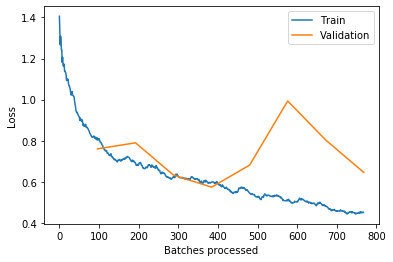

18_224_lr_0.01_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.751402,0.759024,0.261261,0.738739,00:30
1,0.677117,0.506965,0.162162,0.837838,00:31
2,0.654300,0.778380,0.292793,0.707207,00:30
3,0.618031,0.637230,0.225225,0.774775,00:30
4,0.550374,0.577334,0.202703,0.797297,00:30
5,0.498389,0.602232,0.207207,0.792793,00:30
6,0.490540,0.656515,0.198198,0.801802,00:30
7,0.466007,0.657115,0.211712,0.788288,00:30


Better model found at epoch 0 with accuracy value: 0.7387387156486511.
Better model found at epoch 1 with accuracy value: 0.837837815284729.


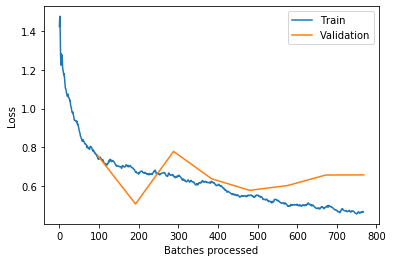

18_224_lr_0.01_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.811515,0.722315,0.216216,0.783784,00:30
1,0.722296,0.729545,0.342342,0.657658,00:30
2,0.647711,0.752418,0.292793,0.707207,00:30
3,0.609007,0.792451,0.283784,0.716216,00:30
4,0.557056,0.503305,0.139640,0.860360,00:30
5,0.515083,0.762934,0.238739,0.761261,00:31
6,0.486702,0.785670,0.234234,0.765766,00:30
7,0.453622,0.917957,0.265766,0.734234,00:30


Better model found at epoch 0 with accuracy value: 0.7837837934494019.
Better model found at epoch 4 with accuracy value: 0.8603603839874268.


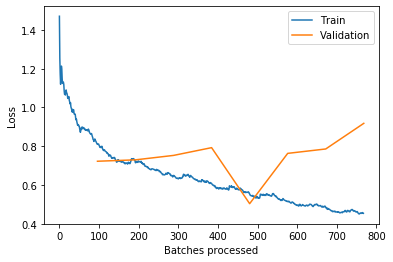

18_224_lr_0.01_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.876341,0.764099,0.256757,0.743243,00:30
1,0.706770,0.727214,0.198198,0.801802,00:31
2,0.676930,0.563677,0.211712,0.788288,00:30
3,0.605827,1.392094,0.441441,0.558559,00:30
4,0.581319,0.529126,0.144144,0.855856,00:31
5,0.530423,0.591164,0.184685,0.815315,00:31
6,0.492627,0.790724,0.234234,0.765766,00:31
7,0.468225,0.815444,0.247748,0.752252,00:31


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 4 with accuracy value: 0.8558558821678162.


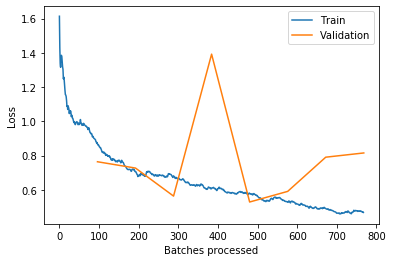

saved stats to: stats\18_224_stats.p


In [52]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [53]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.178   Loss -- best: 0.469  med: 0.596

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.140   accuracy: 0.860   loss:0.5082
18_224_lr_0.01_cyc_8_i8  error_rate: 0.140   accuracy: 0.860   loss:0.5033
18_224_lr_0.1_cyc_4   error_rate: 0.144   accuracy: 0.856   loss:0.5921
18_224_lr_0.01_cyc_8_i9  error_rate: 0.144   accuracy: 0.856   loss:0.5291
18_224_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.149   accuracy: 0.851   loss:0.5775
18_224_lr_0.01_cyc_8  error_rate: 0.149   accuracy: 0.851   loss:0.5160
18_224_lr_0.1_cyc_8   error_rate: 0.149   accuracy: 0.851   loss:0.5172
18_224_lr_0.01_cyc_8_i0  error_rate: 0.153   accuracy: 0.847   loss:0.5455


18_224_lr_0.01_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.831563,0.659749,0.207207,0.792793,00:31
1,0.691082,0.802787,0.364865,0.635135,00:31
2,0.586799,0.702229,0.220721,0.779279,00:30
3,0.523279,0.582727,0.180180,0.819820,00:31


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.


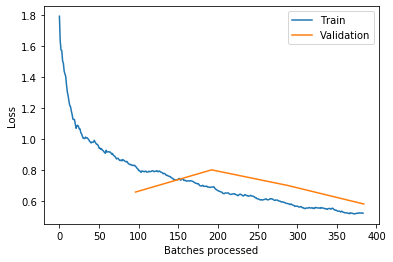

18_224_lr_0.01_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.798531,0.662870,0.234234,0.765766,00:31
1,0.683551,0.708294,0.256757,0.743243,00:31
2,0.609645,0.919622,0.306306,0.693694,00:31
3,0.517555,0.762482,0.252252,0.747748,00:31


Better model found at epoch 0 with accuracy value: 0.7657657861709595.


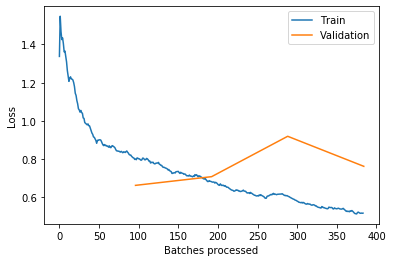

18_224_lr_0.01_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.797594,0.805420,0.319820,0.680180,00:30
1,0.696437,0.783803,0.306306,0.693694,00:31
2,0.575551,0.728454,0.211712,0.788288,00:31
3,0.511725,0.716182,0.220721,0.779279,00:31


Better model found at epoch 0 with accuracy value: 0.6801801919937134.
Better model found at epoch 1 with accuracy value: 0.6936936974525452.
Better model found at epoch 2 with accuracy value: 0.7882882952690125.


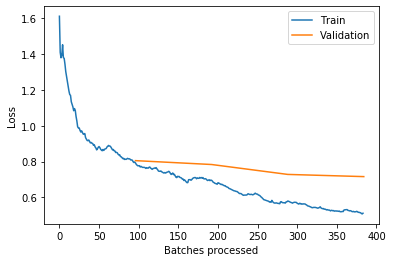

18_224_lr_0.01_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.865507,0.872960,0.396396,0.603604,00:30
1,0.688673,0.492046,0.220721,0.779279,00:30
2,0.608002,0.761352,0.270270,0.729730,00:30
3,0.521573,0.583498,0.193694,0.806306,00:31


Better model found at epoch 0 with accuracy value: 0.6036036014556885.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.


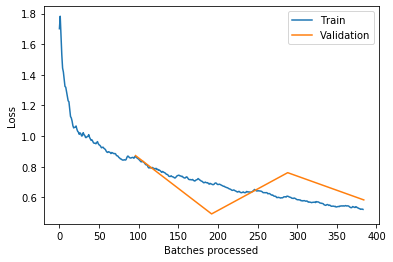

18_224_lr_0.01_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.796290,0.505726,0.207207,0.792793,00:30
1,0.645062,0.508909,0.198198,0.801802,00:30
2,0.566532,0.664643,0.193694,0.806306,00:31
3,0.518365,0.760092,0.247748,0.752252,00:30


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.


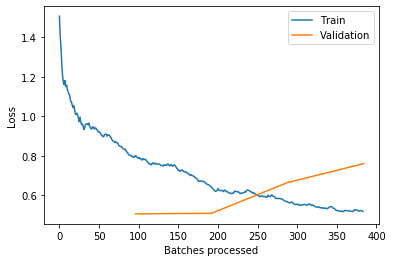

18_224_lr_0.01_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.777976,1.211248,0.382883,0.617117,00:30
1,0.700405,1.142596,0.468468,0.531532,00:30
2,0.604688,0.488816,0.139640,0.860360,00:30
3,0.518017,0.560964,0.166667,0.833333,00:30


Better model found at epoch 0 with accuracy value: 0.6171171069145203.
Better model found at epoch 2 with accuracy value: 0.8603603839874268.


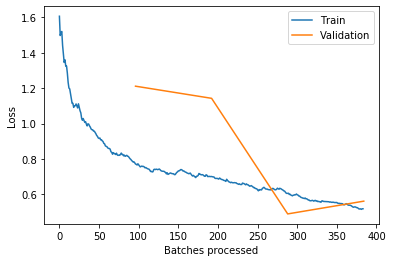

18_224_lr_0.01_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.758077,0.792650,0.301802,0.698198,00:31
1,0.716387,0.638807,0.229730,0.770270,00:30
2,0.597864,0.691518,0.256757,0.743243,00:31
3,0.510729,0.590929,0.207207,0.792793,00:30


Better model found at epoch 0 with accuracy value: 0.6981981992721558.
Better model found at epoch 1 with accuracy value: 0.7702702879905701.
Better model found at epoch 3 with accuracy value: 0.792792797088623.


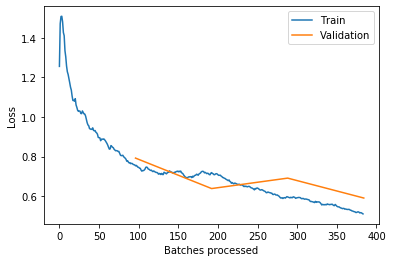

18_224_lr_0.01_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.830338,0.971159,0.333333,0.666667,00:30
1,0.688356,1.524460,0.594595,0.405405,00:31
2,0.570328,0.829821,0.252252,0.747748,00:30
3,0.529787,0.713771,0.202703,0.797297,00:30


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 2 with accuracy value: 0.7477477192878723.
Better model found at epoch 3 with accuracy value: 0.7972972989082336.


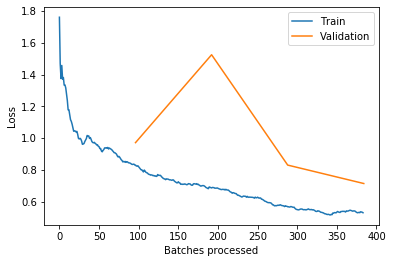

18_224_lr_0.01_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.809480,0.924148,0.378378,0.621622,00:31
1,0.702481,0.756950,0.256757,0.743243,00:30
2,0.601085,0.622674,0.202703,0.797297,00:31
3,0.510004,0.630801,0.193694,0.806306,00:30


Better model found at epoch 0 with accuracy value: 0.6216216087341309.
Better model found at epoch 1 with accuracy value: 0.7432432174682617.
Better model found at epoch 2 with accuracy value: 0.7972972989082336.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.


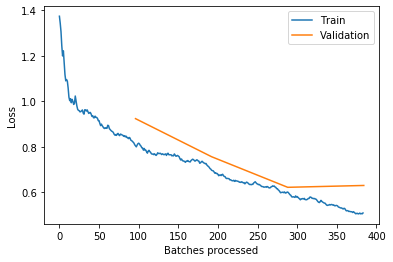

18_224_lr_0.01_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.795166,0.799555,0.351351,0.648649,00:30
1,0.679024,0.699042,0.292793,0.707207,00:30
2,0.599286,0.576265,0.198198,0.801802,00:31
3,0.539019,0.599863,0.211712,0.788288,00:31


Better model found at epoch 0 with accuracy value: 0.6486485600471497.
Better model found at epoch 1 with accuracy value: 0.707207202911377.
Better model found at epoch 2 with accuracy value: 0.8018018007278442.


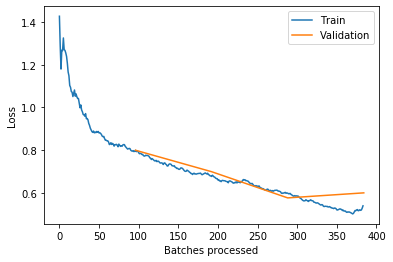

saved stats to: stats\18_224_stats.p


In [54]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [55]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.185   Loss -- best: 0.469  med: 0.596

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.140   accuracy: 0.860   loss:0.5082
18_224_lr_0.01_cyc_8_i8  error_rate: 0.140   accuracy: 0.860   loss:0.5033
18_224_lr_0.01_cyc_4_i5  error_rate: 0.140   accuracy: 0.860   loss:0.4888
18_224_lr_0.1_cyc_4   error_rate: 0.144   accuracy: 0.856   loss:0.5921
18_224_lr_0.01_cyc_8_i9  error_rate: 0.144   accuracy: 0.856   loss:0.5291
18_224_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.149   accuracy: 0.851   loss:0.5775
18_224_lr_0.01_cyc_8  error_rate: 0.149   accuracy: 0.851   loss:0.5160
18_224_lr_0.1_cyc_8   error_rate: 0.149   accuracy: 0.851   loss:0.5172


18_224_lr_0.01_cyc_12_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.827535,0.643819,0.220721,0.779279,00:30
1,0.688046,0.662959,0.202703,0.797297,00:30
2,0.659489,0.676650,0.279279,0.720721,00:30
3,0.631352,0.651680,0.207207,0.792793,00:30
4,0.600702,0.526858,0.166667,0.833333,00:30
5,0.543423,1.315017,0.396396,0.603604,00:31
6,0.532900,0.459172,0.148649,0.851351,00:30
7,0.511797,0.591624,0.144144,0.855856,00:30
8,0.470462,0.710555,0.216216,0.783784,00:31
9,0.446941,0.778884,0.229730,0.770270,00:30


Better model found at epoch 0 with accuracy value: 0.7792792916297913.
Better model found at epoch 1 with accuracy value: 0.7972972989082336.
Better model found at epoch 4 with accuracy value: 0.8333333134651184.
Better model found at epoch 6 with accuracy value: 0.8513513803482056.
Better model found at epoch 7 with accuracy value: 0.8558558821678162.


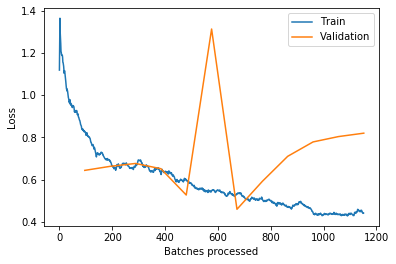

18_224_lr_0.01_cyc_12_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.834711,0.640850,0.207207,0.792793,00:31
1,0.690889,0.691468,0.243243,0.756757,00:31
2,0.639627,0.456453,0.148649,0.851351,00:30
3,0.642282,0.681563,0.261261,0.738739,00:30
4,0.600419,0.723778,0.247748,0.752252,00:31
5,0.546633,1.141172,0.328829,0.671171,00:31
6,0.534551,0.813934,0.279279,0.720721,00:30
7,0.507722,0.436718,0.135135,0.864865,00:30
8,0.482671,0.689794,0.211712,0.788288,00:30
9,0.457689,0.827133,0.265766,0.734234,00:30


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 2 with accuracy value: 0.8513513803482056.
Better model found at epoch 7 with accuracy value: 0.8648648858070374.


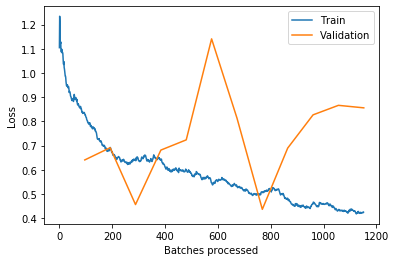

18_224_lr_0.01_cyc_12_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.818619,0.883108,0.270270,0.729730,00:30
1,0.692935,0.659168,0.225225,0.774775,00:30
2,0.653535,0.477442,0.171171,0.828829,00:30
3,0.624609,0.969686,0.346847,0.653153,00:30
4,0.587281,0.716798,0.243243,0.756757,00:31
5,0.576645,0.553074,0.153153,0.846847,00:30
6,0.539726,0.819642,0.292793,0.707207,00:30
7,0.499170,0.711856,0.256757,0.743243,00:30
8,0.490225,0.921810,0.328829,0.671171,00:30
9,0.457759,0.826207,0.243243,0.756757,00:31


Better model found at epoch 0 with accuracy value: 0.7297297120094299.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.
Better model found at epoch 5 with accuracy value: 0.8468468189239502.


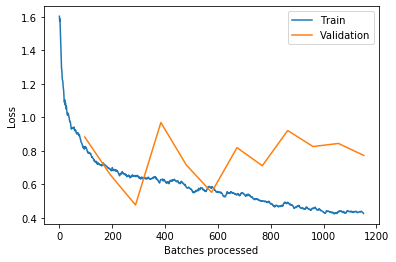

18_224_lr_0.01_cyc_12_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.821297,0.681696,0.220721,0.779279,00:30
1,0.674369,0.636180,0.229730,0.770270,00:30
2,0.657618,0.672620,0.216216,0.783784,00:30
3,0.605151,0.954667,0.328829,0.671171,00:30
4,0.596074,0.660388,0.270270,0.729730,00:31
5,0.564179,0.580687,0.202703,0.797297,00:30
6,0.531004,0.538747,0.166667,0.833333,00:30
7,0.503513,0.661057,0.184685,0.815315,00:31
8,0.476418,0.751331,0.189189,0.810811,00:30
9,0.465067,0.559395,0.184685,0.815315,00:30


Better model found at epoch 0 with accuracy value: 0.7792792916297913.
Better model found at epoch 2 with accuracy value: 0.7837837934494019.
Better model found at epoch 5 with accuracy value: 0.7972972989082336.
Better model found at epoch 6 with accuracy value: 0.8333333134651184.


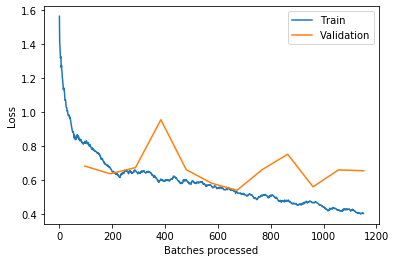

18_224_lr_0.01_cyc_12_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.840342,0.707758,0.252252,0.747748,00:30
1,0.674469,0.772016,0.270270,0.729730,00:30
2,0.663530,0.794676,0.256757,0.743243,00:30
3,0.631545,0.927184,0.346847,0.653153,00:30
4,0.590680,1.030811,0.400901,0.599099,00:30
5,0.579428,0.716669,0.225225,0.774775,00:30
6,0.565603,0.604911,0.220721,0.779279,00:30
7,0.519096,0.550845,0.162162,0.837838,00:31
8,0.492027,0.758545,0.252252,0.747748,00:30
9,0.460811,0.785218,0.274775,0.725225,00:30


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 5 with accuracy value: 0.7747747898101807.
Better model found at epoch 6 with accuracy value: 0.7792792916297913.
Better model found at epoch 7 with accuracy value: 0.837837815284729.


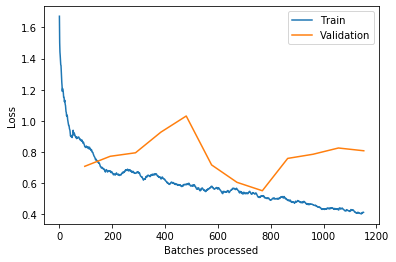

18_224_lr_0.01_cyc_12_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.825037,0.635160,0.198198,0.801802,00:30
1,0.693607,0.926174,0.292793,0.707207,00:31
2,0.679107,0.694274,0.288288,0.711712,00:30
3,0.619375,0.936929,0.315315,0.684685,00:31
4,0.603473,0.659979,0.207207,0.792793,00:30
5,0.560396,0.920050,0.328829,0.671171,00:31
6,0.515503,0.745233,0.243243,0.756757,00:33
7,0.494274,0.824702,0.283784,0.716216,00:32
8,0.474229,0.664162,0.207207,0.792793,00:30
9,0.463257,0.763134,0.225225,0.774775,00:30


Better model found at epoch 0 with accuracy value: 0.8018018007278442.


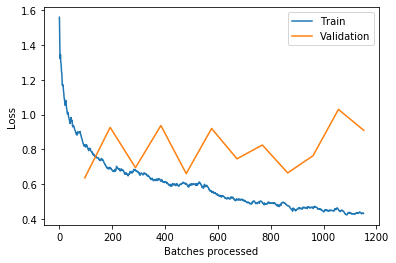

18_224_lr_0.01_cyc_12_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.834052,0.713397,0.229730,0.770270,00:30
1,0.713000,0.589880,0.198198,0.801802,00:30
2,0.678607,0.937321,0.333333,0.666667,00:30
3,0.628280,0.591519,0.207207,0.792793,00:30
4,0.591971,0.788956,0.297297,0.702703,00:30
5,0.550946,0.581513,0.202703,0.797297,00:30
6,0.529305,0.491049,0.130631,0.869369,00:31
7,0.509349,0.800227,0.310811,0.689189,00:30
8,0.487868,0.515953,0.148649,0.851351,00:31
9,0.463338,0.901710,0.252252,0.747748,00:30


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 1 with accuracy value: 0.8018018007278442.
Better model found at epoch 6 with accuracy value: 0.869369387626648.


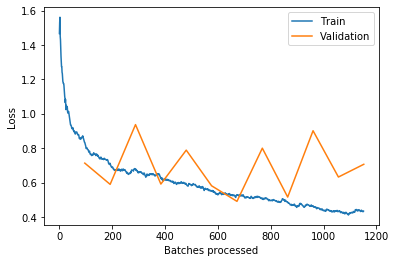

18_224_lr_0.01_cyc_12_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.837097,0.736959,0.243243,0.756757,00:30
1,0.676542,0.548125,0.184685,0.815315,00:31
2,0.641012,0.821555,0.297297,0.702703,00:30
3,0.620669,1.006637,0.328829,0.671171,00:31
4,0.600805,0.543376,0.153153,0.846847,00:30
5,0.568776,0.576054,0.184685,0.815315,00:30
6,0.525807,0.566109,0.162162,0.837838,00:31
7,0.494850,0.903458,0.247748,0.752252,00:30
8,0.467321,0.889805,0.288288,0.711712,00:30
9,0.448249,0.740639,0.234234,0.765766,00:30


Better model found at epoch 0 with accuracy value: 0.7567567825317383.
Better model found at epoch 1 with accuracy value: 0.815315306186676.
Better model found at epoch 4 with accuracy value: 0.8468468189239502.


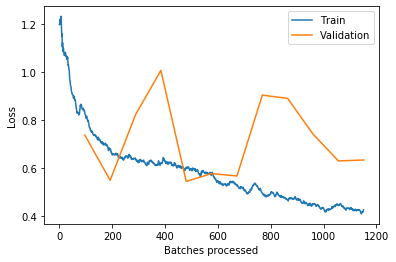

18_224_lr_0.01_cyc_12_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.839630,0.700808,0.225225,0.774775,00:30
1,0.730678,0.627036,0.243243,0.756757,00:30
2,0.673522,0.691979,0.283784,0.716216,00:31
3,0.642258,1.885221,0.414414,0.585586,00:30
4,0.590255,0.471259,0.135135,0.864865,00:30
5,0.565584,0.649447,0.225225,0.774775,00:30
6,0.544205,0.620889,0.319820,0.680180,00:30
7,0.514580,0.623960,0.216216,0.783784,00:30
8,0.497560,0.538259,0.175676,0.824324,00:30
9,0.464785,0.611817,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 4 with accuracy value: 0.8648648858070374.


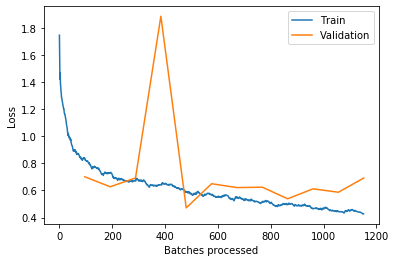

18_224_lr_0.01_cyc_12_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.840343,0.584942,0.193694,0.806306,00:30
1,0.690222,0.767371,0.261261,0.738739,00:30
2,0.665604,0.433823,0.148649,0.851351,00:31
3,0.623318,0.899229,0.450450,0.549550,00:30
4,0.591158,0.689676,0.207207,0.792793,00:31
5,0.558855,0.457773,0.153153,0.846847,00:31
6,0.535475,0.577396,0.193694,0.806306,00:31
7,0.498035,0.592567,0.180180,0.819820,00:32
8,0.501535,0.733651,0.243243,0.756757,00:30
9,0.472753,0.616135,0.184685,0.815315,00:31


Better model found at epoch 0 with accuracy value: 0.8063063025474548.
Better model found at epoch 2 with accuracy value: 0.8513513803482056.


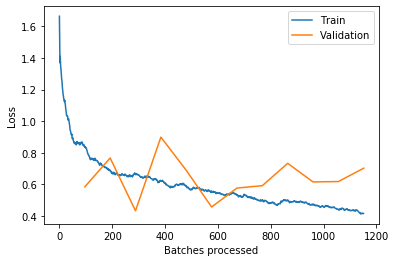

saved stats to: stats\18_224_stats.p


In [56]:
for i in range(10):
    for key, params in get_params(all_cycles=[12], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [57]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.178   Loss -- best: 0.434  med: 0.591

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.01_cyc_12_i6  error_rate: 0.131   accuracy: 0.869   loss:0.4910
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_12_i8  error_rate: 0.135   accuracy: 0.865   loss:0.4713
18_224_lr_0.01_cyc_12_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4367
18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.140   accuracy: 0.860   loss:0.5082
18_224_lr_0.01_cyc_8_i8  error_rate: 0.140   accuracy: 0.860   loss:0.5033
18_224_lr_0.01_cyc_4_i5  error_rate: 0.140   accuracy: 0.860   loss:0.4888
18_224_lr_0.1_cyc_4   error_rate: 0.144   accuracy: 0.856   loss:0.5921
18_224_lr_0.01_cyc_8_i9  error_rate: 0.144   accuracy: 0.856   loss:0.5291


18_224_lr_0.02_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.768519,0.888249,0.301802,0.698198,00:31
1,0.711268,0.846075,0.355856,0.644144,00:30
2,0.719288,1.099573,0.454955,0.545045,00:31
3,0.615290,0.506709,0.162162,0.837838,00:31
4,0.572429,0.490955,0.148649,0.851351,00:31
5,0.529358,0.779895,0.256757,0.743243,00:31
6,0.508419,0.585109,0.171171,0.828829,00:31
7,0.456323,0.753744,0.234234,0.765766,00:31


Better model found at epoch 0 with accuracy value: 0.6981981992721558.
Better model found at epoch 3 with accuracy value: 0.837837815284729.
Better model found at epoch 4 with accuracy value: 0.8513513803482056.


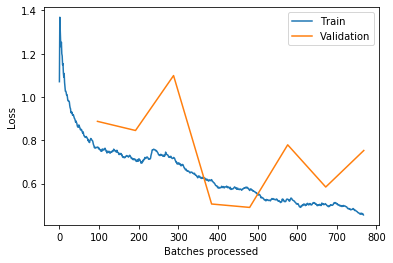

18_224_lr_0.02_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.787737,0.799900,0.288288,0.711712,00:31
1,0.759895,0.695018,0.225225,0.774775,00:31
2,0.695308,0.576893,0.193694,0.806306,00:30
3,0.638735,0.823670,0.270270,0.729730,00:30
4,0.584926,0.937656,0.297297,0.702703,00:30
5,0.544795,0.565978,0.184685,0.815315,00:31
6,0.515680,0.608238,0.180180,0.819820,00:31
7,0.471971,0.736086,0.238739,0.761261,00:31


Better model found at epoch 0 with accuracy value: 0.7117117047309875.
Better model found at epoch 1 with accuracy value: 0.7747747898101807.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 5 with accuracy value: 0.815315306186676.
Better model found at epoch 6 with accuracy value: 0.8198198080062866.


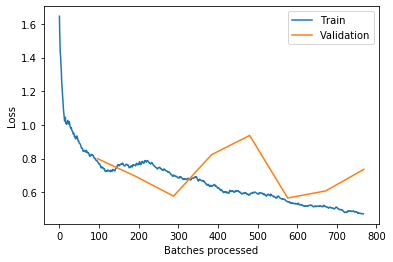

18_224_lr_0.02_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.787655,0.701452,0.261261,0.738739,00:31
1,0.736737,0.695243,0.283784,0.716216,00:30
2,0.698471,0.556822,0.207207,0.792793,00:31
3,0.619607,0.457615,0.144144,0.855856,00:31
4,0.580813,0.433790,0.144144,0.855856,00:31
5,0.536076,0.676550,0.220721,0.779279,00:30
6,0.501674,0.836599,0.297297,0.702703,00:31
7,0.473036,0.709398,0.238739,0.761261,00:30


Better model found at epoch 0 with accuracy value: 0.7387387156486511.
Better model found at epoch 2 with accuracy value: 0.792792797088623.
Better model found at epoch 3 with accuracy value: 0.8558558821678162.


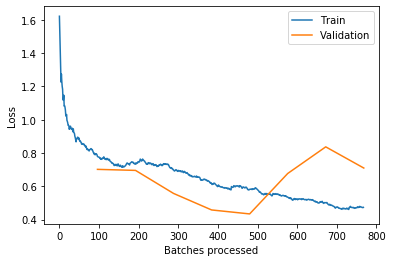

18_224_lr_0.02_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.772311,0.579302,0.193694,0.806306,00:31
1,0.768812,1.110805,0.346847,0.653153,00:31
2,0.689788,0.474399,0.166667,0.833333,00:31
3,0.627383,0.585271,0.234234,0.765766,00:31
4,0.578288,0.708531,0.229730,0.770270,00:30
5,0.537516,0.509033,0.175676,0.824324,00:30
6,0.516211,0.777629,0.256757,0.743243,00:30
7,0.468472,0.665881,0.193694,0.806306,00:30


Better model found at epoch 0 with accuracy value: 0.8063063025474548.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.


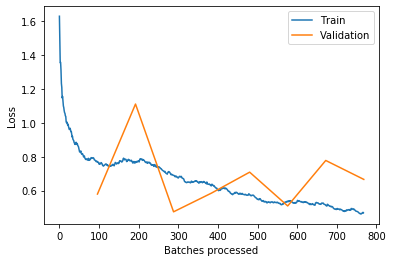

18_224_lr_0.02_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.775995,0.723839,0.288288,0.711712,00:30
1,0.721611,0.688136,0.265766,0.734234,00:31
2,0.715723,0.763714,0.369369,0.630631,00:30
3,0.623187,0.509486,0.157658,0.842342,00:31
4,0.577091,0.539566,0.180180,0.819820,00:30
5,0.538928,0.490096,0.135135,0.864865,00:30
6,0.487264,0.638360,0.184685,0.815315,00:30
7,0.468507,0.633644,0.180180,0.819820,00:31


Better model found at epoch 0 with accuracy value: 0.7117117047309875.
Better model found at epoch 1 with accuracy value: 0.7342342138290405.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.
Better model found at epoch 5 with accuracy value: 0.8648648858070374.


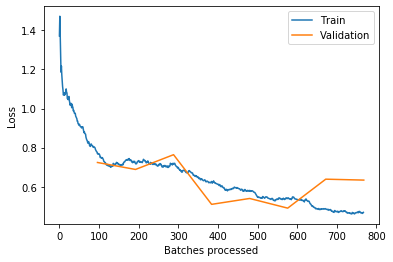

18_224_lr_0.02_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.776703,0.683732,0.288288,0.711712,00:30
1,0.777359,0.704361,0.279279,0.720721,00:30
2,0.682468,0.582791,0.166667,0.833333,00:31
3,0.626272,0.511837,0.193694,0.806306,00:31
4,0.591545,1.063466,0.400901,0.599099,00:31
5,0.527778,0.802275,0.310811,0.689189,00:31
6,0.505069,0.652201,0.198198,0.801802,00:31
7,0.476451,0.732505,0.243243,0.756757,00:30


Better model found at epoch 0 with accuracy value: 0.7117117047309875.
Better model found at epoch 1 with accuracy value: 0.7207207083702087.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.


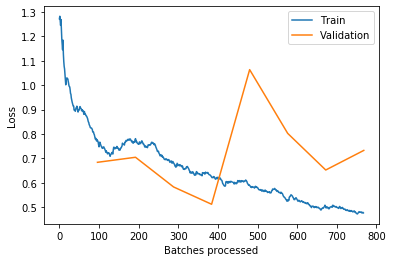

18_224_lr_0.02_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.788553,0.787331,0.265766,0.734234,00:31
1,0.802299,0.573155,0.207207,0.792793,00:31
2,0.669454,1.157602,0.351351,0.648649,00:30
3,0.617652,0.664290,0.216216,0.783784,00:31
4,0.583852,0.617776,0.162162,0.837838,00:30
5,0.538376,0.712332,0.216216,0.783784,00:31
6,0.490254,0.801726,0.252252,0.747748,00:30
7,0.463794,0.700181,0.207207,0.792793,00:31


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 1 with accuracy value: 0.792792797088623.
Better model found at epoch 4 with accuracy value: 0.837837815284729.


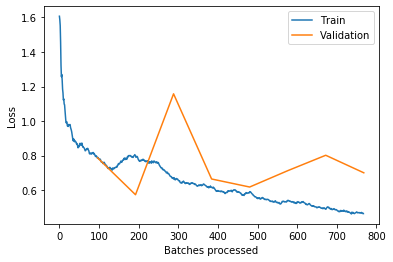

18_224_lr_0.02_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.808932,0.572498,0.207207,0.792793,00:31
1,0.733543,1.437138,0.481982,0.518018,00:31
2,0.696804,0.628315,0.211712,0.788288,00:30
3,0.623709,0.574847,0.162162,0.837838,00:30
4,0.585106,0.683007,0.216216,0.783784,00:31
5,0.542136,0.540092,0.166667,0.833333,00:30
6,0.486050,0.707499,0.198198,0.801802,00:30
7,0.455884,0.805617,0.225225,0.774775,00:30


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 3 with accuracy value: 0.837837815284729.


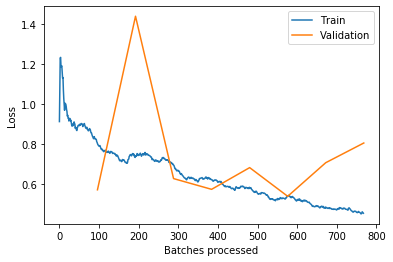

18_224_lr_0.02_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.773200,0.847278,0.256757,0.743243,00:30
1,0.789816,1.429150,0.391892,0.608108,00:30
2,0.696358,0.643889,0.270270,0.729730,00:31
3,0.618677,0.652919,0.198198,0.801802,00:31
4,0.593078,0.546865,0.189189,0.810811,00:30
5,0.551084,0.628134,0.175676,0.824324,00:30
6,0.501943,0.662099,0.198198,0.801802,00:31
7,0.475292,0.668545,0.193694,0.806306,00:31


Better model found at epoch 0 with accuracy value: 0.7432432174682617.
Better model found at epoch 3 with accuracy value: 0.8018018007278442.
Better model found at epoch 4 with accuracy value: 0.8108108043670654.
Better model found at epoch 5 with accuracy value: 0.8243243098258972.


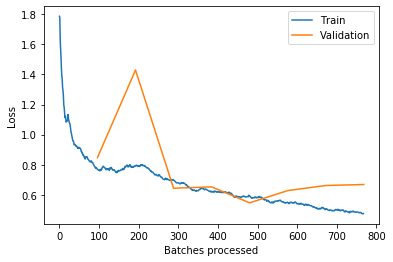

18_224_lr_0.02_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.776733,0.756597,0.274775,0.725225,00:31
1,0.737186,0.713882,0.306306,0.693694,00:30
2,0.690328,0.739761,0.292793,0.707207,00:30
3,0.616934,0.829706,0.315315,0.684685,00:30
4,0.590239,0.678759,0.234234,0.765766,00:31
5,0.539403,0.762342,0.234234,0.765766,00:30
6,0.511216,0.762934,0.220721,0.779279,00:30
7,0.473050,0.703368,0.216216,0.783784,00:30


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 4 with accuracy value: 0.7657657861709595.
Better model found at epoch 6 with accuracy value: 0.7792792916297913.
Better model found at epoch 7 with accuracy value: 0.7837837934494019.


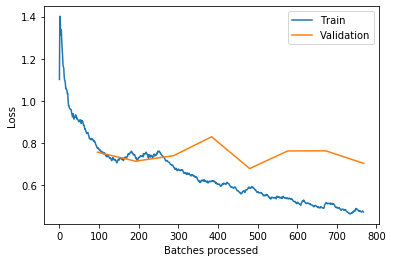

saved stats to: stats\18_224_stats.p


In [58]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [59]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.176   Loss -- best: 0.434  med: 0.591

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.01_cyc_12_i6  error_rate: 0.131   accuracy: 0.869   loss:0.4910
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_12_i8  error_rate: 0.135   accuracy: 0.865   loss:0.4713
18_224_lr_0.01_cyc_12_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4367
18_224_lr_0.02_cyc_8_i4  error_rate: 0.135   accuracy: 0.865   loss:0.4901
18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.140   accuracy: 0.860   loss:0.5082
18_224_lr_0.01_cyc_8_i8  error_rate: 0.140   accuracy: 0.860   loss:0.5033
18_224_lr_0.01_cyc_4_i5  error_rate: 0.140   accuracy: 0.860   loss:0.4888
18_224_lr_0.1_cyc_4   error_rate: 0.144   accuracy: 0.856   loss:0.5921


18_224_lr_0.02_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.804531,0.796699,0.337838,0.662162,00:30
1,0.798342,0.548166,0.162162,0.837838,00:30
2,0.642495,0.781646,0.238739,0.761261,00:31
3,0.532546,0.763768,0.238739,0.761261,00:30


Better model found at epoch 0 with accuracy value: 0.662162184715271.
Better model found at epoch 1 with accuracy value: 0.837837815284729.


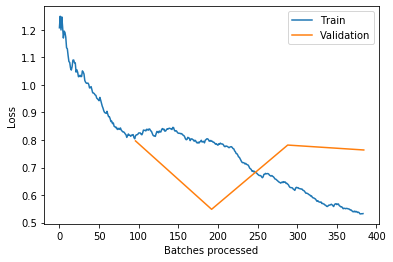

18_224_lr_0.02_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.810382,1.089792,0.360360,0.639640,00:31
1,0.771595,1.181950,0.324324,0.675676,00:31
2,0.615767,0.508325,0.148649,0.851351,00:31
3,0.531470,0.719682,0.229730,0.770270,00:31


Better model found at epoch 0 with accuracy value: 0.6396396160125732.
Better model found at epoch 1 with accuracy value: 0.6756756901741028.
Better model found at epoch 2 with accuracy value: 0.8513513803482056.


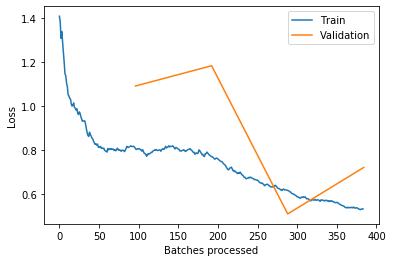

18_224_lr_0.02_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.811739,1.234997,0.355856,0.644144,00:31
1,0.755955,0.606138,0.189189,0.810811,00:31
2,0.619876,0.743888,0.238739,0.761261,00:31
3,0.527500,0.615396,0.171171,0.828829,00:30


Better model found at epoch 0 with accuracy value: 0.6441441178321838.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.
Better model found at epoch 3 with accuracy value: 0.8288288116455078.


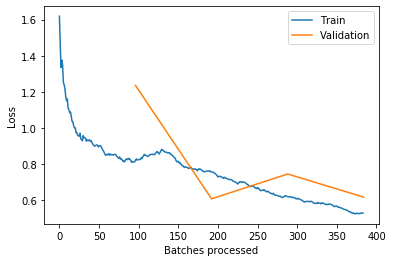

18_224_lr_0.02_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.779395,0.886435,0.306306,0.693694,00:30
1,0.768489,0.609261,0.229730,0.770270,00:30
2,0.657240,0.745306,0.234234,0.765766,00:31
3,0.540778,0.802191,0.225225,0.774775,00:31


Better model found at epoch 0 with accuracy value: 0.6936936974525452.
Better model found at epoch 1 with accuracy value: 0.7702702879905701.
Better model found at epoch 3 with accuracy value: 0.7747747898101807.


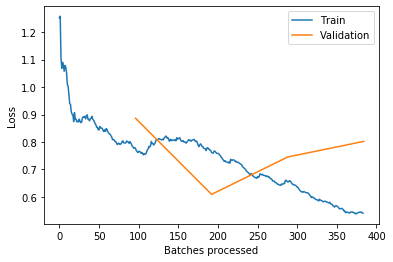

18_224_lr_0.02_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.818422,1.133778,0.333333,0.666667,00:30
1,0.740980,0.603478,0.162162,0.837838,00:31
2,0.594115,0.625954,0.148649,0.851351,00:30
3,0.523519,0.650765,0.175676,0.824324,00:31


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 1 with accuracy value: 0.837837815284729.
Better model found at epoch 2 with accuracy value: 0.8513513803482056.


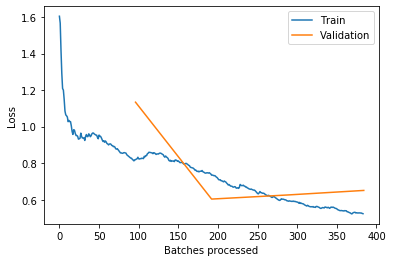

18_224_lr_0.02_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.837196,0.770814,0.274775,0.725225,00:31
1,0.749633,0.699648,0.184685,0.815315,00:31
2,0.596774,0.759498,0.234234,0.765766,00:30
3,0.523803,0.643079,0.189189,0.810811,00:30


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 1 with accuracy value: 0.815315306186676.


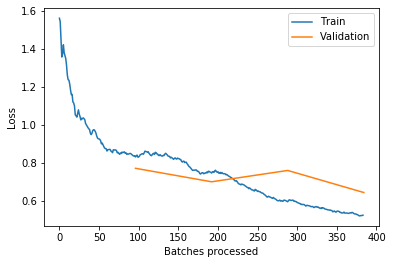

18_224_lr_0.02_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.821397,0.809361,0.315315,0.684685,00:30
1,0.714503,0.540577,0.180180,0.819820,00:31
2,0.594637,0.843493,0.288288,0.711712,00:30
3,0.530064,0.642991,0.198198,0.801802,00:31


Better model found at epoch 0 with accuracy value: 0.684684693813324.
Better model found at epoch 1 with accuracy value: 0.8198198080062866.


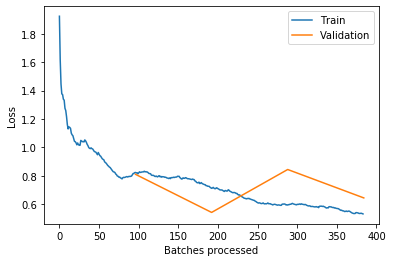

18_224_lr_0.02_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.834585,1.428231,0.463964,0.536036,00:30
1,0.767098,0.828148,0.328829,0.671171,00:31
2,0.608619,0.487025,0.139640,0.860360,00:30
3,0.563806,0.565482,0.166667,0.833333,00:30


Better model found at epoch 0 with accuracy value: 0.5360360145568848.
Better model found at epoch 1 with accuracy value: 0.6711711883544922.
Better model found at epoch 2 with accuracy value: 0.8603603839874268.


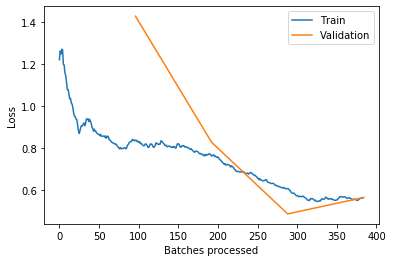

18_224_lr_0.02_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.814571,0.920391,0.315315,0.684685,00:30
1,0.737145,0.518801,0.153153,0.846847,00:30
2,0.604284,0.706064,0.211712,0.788288,00:31
3,0.539465,0.707273,0.234234,0.765766,00:30


Better model found at epoch 0 with accuracy value: 0.684684693813324.
Better model found at epoch 1 with accuracy value: 0.8468468189239502.


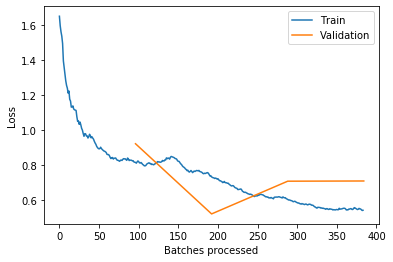

18_224_lr_0.02_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.805088,0.682625,0.283784,0.716216,00:31
1,0.730859,0.566948,0.211712,0.788288,00:32
2,0.634324,1.116533,0.378378,0.621622,00:31
3,0.531357,0.894635,0.301802,0.698198,00:30


Better model found at epoch 0 with accuracy value: 0.7162162065505981.
Better model found at epoch 1 with accuracy value: 0.7882882952690125.


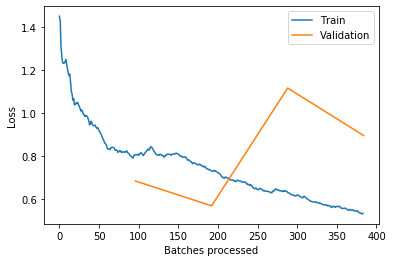

saved stats to: stats\18_224_stats.p


In [60]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [61]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.173   Loss -- best: 0.434  med: 0.588

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.01_cyc_12_i6  error_rate: 0.131   accuracy: 0.869   loss:0.4910
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_12_i8  error_rate: 0.135   accuracy: 0.865   loss:0.4713
18_224_lr_0.01_cyc_12_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4367
18_224_lr_0.02_cyc_8_i4  error_rate: 0.135   accuracy: 0.865   loss:0.4901
18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.140   accuracy: 0.860   loss:0.5082
18_224_lr_0.01_cyc_8_i8  error_rate: 0.140   accuracy: 0.860   loss:0.5033
18_224_lr_0.01_cyc_4_i5  error_rate: 0.140   accuracy: 0.860   loss:0.4888
18_224_lr_0.02_cyc_4_i7  error_rate: 0.140   accuracy: 0.860   loss:0.4870


18_224_lr_0.03_cyc_8_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.786662,0.996485,0.328829,0.671171,00:31
1,0.808636,0.789951,0.252252,0.747748,00:31
2,0.689747,0.736420,0.328829,0.671171,00:31
3,0.641294,0.714036,0.261261,0.738739,00:31
4,0.603931,0.791505,0.297297,0.702703,00:31
5,0.545481,0.779651,0.229730,0.770270,00:30
6,0.511237,0.761712,0.261261,0.738739,00:31
7,0.476598,0.791599,0.261261,0.738739,00:31


Better model found at epoch 0 with accuracy value: 0.6711711883544922.
Better model found at epoch 1 with accuracy value: 0.7477477192878723.
Better model found at epoch 5 with accuracy value: 0.7702702879905701.


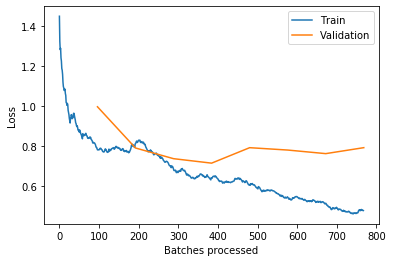

18_224_lr_0.03_cyc_8_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.781847,0.866788,0.270270,0.729730,00:31
1,0.800693,1.278252,0.414414,0.585586,00:31
2,0.720172,0.677312,0.216216,0.783784,00:31
3,0.675861,0.685503,0.193694,0.806306,00:31
4,0.609941,0.645010,0.211712,0.788288,00:30
5,0.569542,0.478497,0.139640,0.860360,00:31
6,0.517442,0.510137,0.153153,0.846847,00:31
7,0.493537,0.550111,0.153153,0.846847,00:30


Better model found at epoch 0 with accuracy value: 0.7297297120094299.
Better model found at epoch 2 with accuracy value: 0.7837837934494019.
Better model found at epoch 3 with accuracy value: 0.8063063025474548.
Better model found at epoch 5 with accuracy value: 0.8603603839874268.


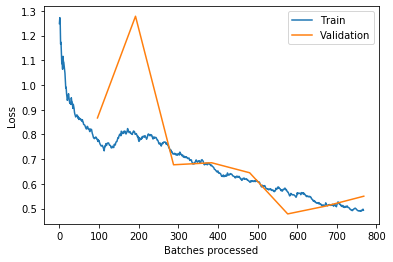

18_224_lr_0.03_cyc_8_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.735206,0.816112,0.333333,0.666667,00:31
1,0.750170,0.921260,0.292793,0.707207,00:31
2,0.749100,0.910094,0.441441,0.558559,00:31
3,0.664378,0.507643,0.175676,0.824324,00:31
4,0.614351,0.570725,0.184685,0.815315,00:31
5,0.569279,0.626063,0.171171,0.828829,00:31
6,0.528565,0.610646,0.157658,0.842342,00:31
7,0.511121,0.661737,0.175676,0.824324,00:31


Better model found at epoch 0 with accuracy value: 0.6666666865348816.
Better model found at epoch 1 with accuracy value: 0.707207202911377.
Better model found at epoch 3 with accuracy value: 0.8243243098258972.
Better model found at epoch 5 with accuracy value: 0.8288288116455078.
Better model found at epoch 6 with accuracy value: 0.8423423171043396.


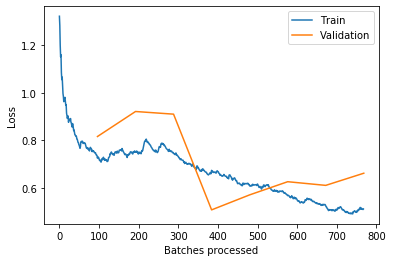

18_224_lr_0.03_cyc_8_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.753464,1.147049,0.382883,0.617117,00:31
1,0.782897,0.717287,0.373874,0.626126,00:31
2,0.702839,1.520497,0.612613,0.387387,00:31
3,0.651981,0.752379,0.360360,0.639640,00:30
4,0.608331,0.486590,0.139640,0.860360,00:31
5,0.543508,0.504401,0.148649,0.851351,00:31
6,0.527636,0.633746,0.198198,0.801802,00:30
7,0.485883,0.612602,0.193694,0.806306,00:31


Better model found at epoch 0 with accuracy value: 0.6171171069145203.
Better model found at epoch 1 with accuracy value: 0.6261261105537415.
Better model found at epoch 3 with accuracy value: 0.6396396160125732.
Better model found at epoch 4 with accuracy value: 0.8603603839874268.


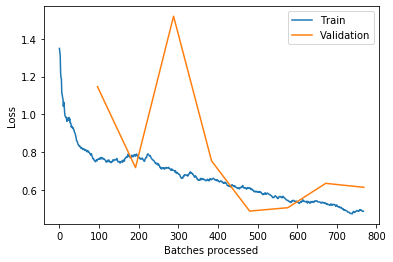

18_224_lr_0.03_cyc_8_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.778186,0.867764,0.274775,0.725225,00:31
1,0.834442,1.326009,0.468468,0.531532,00:31
2,0.739199,0.959777,0.463964,0.536036,00:31
3,0.703685,0.845002,0.382883,0.617117,00:31
4,0.638025,0.553591,0.198198,0.801802,00:31
5,0.545428,0.805487,0.252252,0.747748,00:31
6,0.519454,0.688158,0.225225,0.774775,00:31
7,0.477433,0.723327,0.229730,0.770270,00:31


Better model found at epoch 0 with accuracy value: 0.7252252101898193.
Better model found at epoch 4 with accuracy value: 0.8018018007278442.


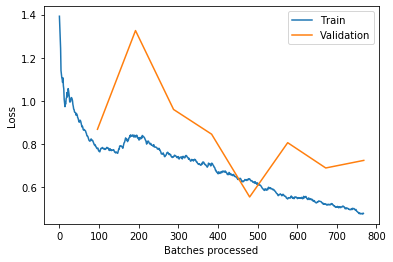

18_224_lr_0.03_cyc_8_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.795800,0.840530,0.351351,0.648649,00:32
1,0.838509,0.720974,0.324324,0.675676,00:31
2,0.712461,0.750450,0.256757,0.743243,00:31
3,0.646512,0.537870,0.171171,0.828829,00:31
4,0.626575,0.774704,0.234234,0.765766,00:30
5,0.564517,0.698296,0.234234,0.765766,00:31
6,0.502220,0.601442,0.184685,0.815315,00:31
7,0.487223,0.688748,0.216216,0.783784,00:31


Better model found at epoch 0 with accuracy value: 0.6486486196517944.
Better model found at epoch 1 with accuracy value: 0.6756756901741028.
Better model found at epoch 2 with accuracy value: 0.7432432174682617.
Better model found at epoch 3 with accuracy value: 0.8288288116455078.


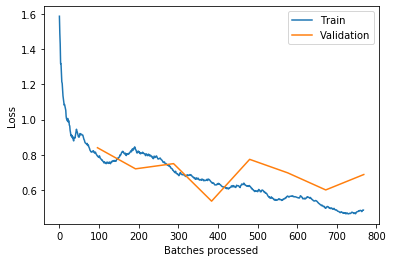

18_224_lr_0.03_cyc_8_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.750274,0.724692,0.310811,0.689189,00:30
1,0.802481,0.721210,0.220721,0.779279,00:31
2,0.729049,0.921692,0.301802,0.698198,00:31
3,0.652812,0.683527,0.243243,0.756757,00:30
4,0.607072,0.478788,0.157658,0.842342,00:30
5,0.582290,0.491197,0.171171,0.828829,00:31
6,0.510487,0.577992,0.207207,0.792793,00:31
7,0.490918,0.692358,0.207207,0.792793,00:31


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 1 with accuracy value: 0.7792792916297913.
Better model found at epoch 4 with accuracy value: 0.8423423171043396.


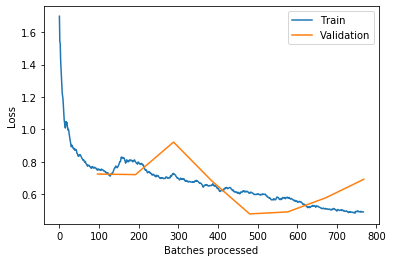

18_224_lr_0.03_cyc_8_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.785028,0.696048,0.310811,0.689189,00:31
1,0.859525,0.912903,0.333333,0.666667,00:31
2,0.744102,1.400102,0.427928,0.572072,00:31
3,0.679766,0.646747,0.180180,0.819820,00:31
4,0.628528,0.563029,0.162162,0.837838,00:31
5,0.561486,0.844535,0.288288,0.711712,00:30
6,0.524933,0.622257,0.180180,0.819820,00:31
7,0.491400,0.580088,0.157658,0.842342,00:31


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.
Better model found at epoch 4 with accuracy value: 0.837837815284729.
Better model found at epoch 7 with accuracy value: 0.8423423171043396.


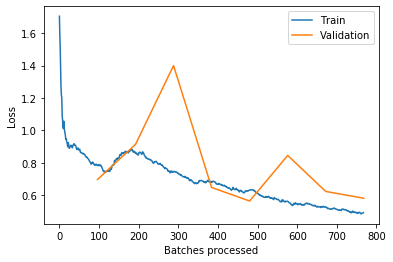

18_224_lr_0.03_cyc_8_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.786807,0.697429,0.292793,0.707207,00:31
1,0.826109,0.618313,0.256757,0.743243,00:31
2,0.732476,0.704982,0.297297,0.702703,00:30
3,0.655719,0.615716,0.207207,0.792793,00:30
4,0.647294,0.574123,0.171171,0.828829,00:30
5,0.575071,0.631934,0.175676,0.824324,00:31
6,0.537405,0.621125,0.193694,0.806306,00:31
7,0.518840,0.599843,0.193694,0.806306,00:31


Better model found at epoch 0 with accuracy value: 0.707207202911377.
Better model found at epoch 1 with accuracy value: 0.7432432174682617.
Better model found at epoch 3 with accuracy value: 0.792792797088623.
Better model found at epoch 4 with accuracy value: 0.8288288116455078.


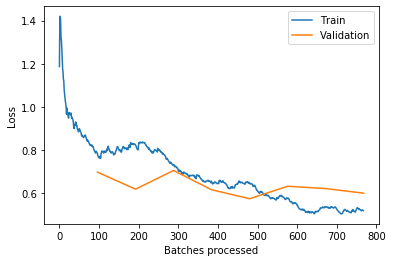

18_224_lr_0.03_cyc_8_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.799350,0.709343,0.310811,0.689189,00:30
1,0.811253,1.008139,0.346847,0.653153,00:31
2,0.740947,0.665239,0.220721,0.779279,00:31
3,0.642191,0.612320,0.261261,0.738739,00:31
4,0.605982,1.303587,0.423423,0.576577,00:31
5,0.573653,0.510695,0.193694,0.806306,00:31
6,0.527099,0.517796,0.180180,0.819820,00:31
7,0.478789,0.571358,0.211712,0.788288,00:31


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 2 with accuracy value: 0.7792792916297913.
Better model found at epoch 5 with accuracy value: 0.8063063025474548.
Better model found at epoch 6 with accuracy value: 0.8198198080062866.


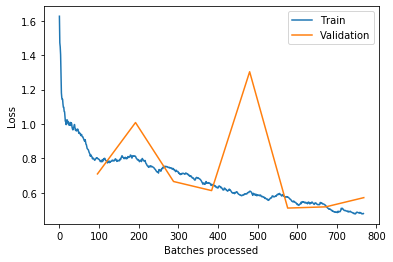

saved stats to: stats\18_224_stats.p


In [62]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [63]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.171   Loss -- best: 0.434  med: 0.583

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.01_cyc_12_i6  error_rate: 0.131   accuracy: 0.869   loss:0.4910
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_12_i8  error_rate: 0.135   accuracy: 0.865   loss:0.4713
18_224_lr_0.01_cyc_12_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4367
18_224_lr_0.02_cyc_8_i4  error_rate: 0.135   accuracy: 0.865   loss:0.4901
18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.140   accuracy: 0.860   loss:0.5082
18_224_lr_0.03_cyc_8_i1  error_rate: 0.140   accuracy: 0.860   loss:0.4785
18_224_lr_0.03_cyc_8_i3  error_rate: 0.140   accuracy: 0.860   loss:0.4866
18_224_lr_0.01_cyc_8_i8  error_rate: 0.140   accuracy: 0.860   loss:0.5033


18_224_lr_0.03_cyc_4_i0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.854597,1.911324,0.545045,0.454955,00:31
1,0.806467,1.275614,0.567568,0.432432,00:31
2,0.625887,0.672385,0.234234,0.765766,00:31
3,0.549050,0.878194,0.301802,0.698198,00:31


Better model found at epoch 0 with accuracy value: 0.45495495200157166.
Better model found at epoch 2 with accuracy value: 0.7657657861709595.


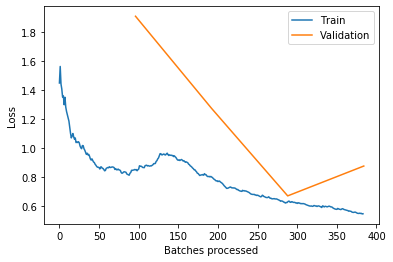

18_224_lr_0.03_cyc_4_i1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.853421,1.231209,0.432432,0.567568,00:31
1,0.750190,0.852480,0.292793,0.707207,00:30
2,0.627164,0.532928,0.166667,0.833333,00:30
3,0.552887,0.490711,0.135135,0.864865,00:31


Better model found at epoch 0 with accuracy value: 0.5675675868988037.
Better model found at epoch 1 with accuracy value: 0.707207202911377.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.
Better model found at epoch 3 with accuracy value: 0.8648648858070374.


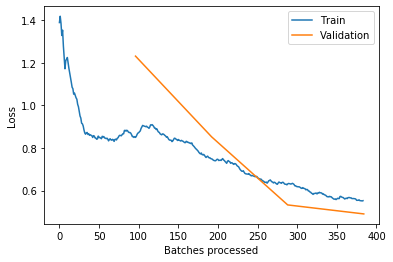

18_224_lr_0.03_cyc_4_i2


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.879294,1.740082,0.495495,0.504505,00:31
1,0.810768,0.795722,0.414414,0.585586,00:31
2,0.628268,0.524127,0.153153,0.846847,00:30
3,0.553385,0.608237,0.139640,0.860360,00:31


Better model found at epoch 0 with accuracy value: 0.5045045018196106.
Better model found at epoch 1 with accuracy value: 0.5855855941772461.
Better model found at epoch 2 with accuracy value: 0.8468468189239502.
Better model found at epoch 3 with accuracy value: 0.8603603839874268.


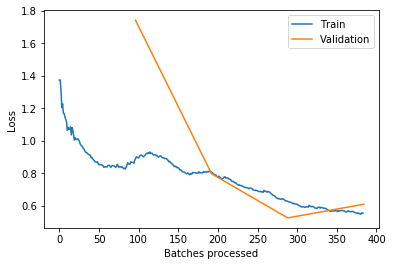

18_224_lr_0.03_cyc_4_i3


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.904410,1.824914,0.522523,0.477477,00:31
1,0.774551,0.720273,0.288288,0.711712,00:30
2,0.638439,0.689951,0.243243,0.756757,00:30
3,0.566798,0.596882,0.180180,0.819820,00:31


Better model found at epoch 0 with accuracy value: 0.477477490901947.
Better model found at epoch 1 with accuracy value: 0.7117117047309875.
Better model found at epoch 2 with accuracy value: 0.7567567825317383.
Better model found at epoch 3 with accuracy value: 0.8198198080062866.


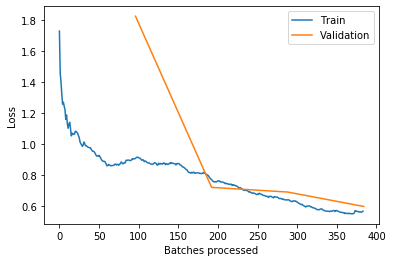

18_224_lr_0.03_cyc_4_i4


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.853870,1.286531,0.306306,0.693694,00:31
1,0.744006,0.854226,0.252252,0.747748,00:31
2,0.611530,0.505867,0.171171,0.828829,00:31
3,0.554150,0.638230,0.220721,0.779279,00:31


Better model found at epoch 0 with accuracy value: 0.6936936974525452.
Better model found at epoch 1 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.


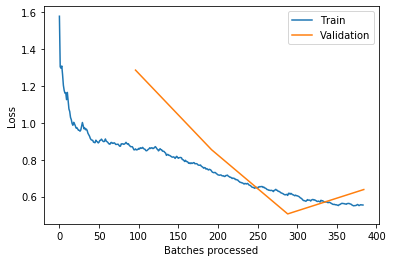

18_224_lr_0.03_cyc_4_i5


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.882876,0.932542,0.409910,0.590090,00:31
1,0.774075,1.049372,0.432432,0.567568,00:31
2,0.631529,0.559531,0.162162,0.837838,00:30
3,0.548999,0.581657,0.157658,0.842342,00:30


Better model found at epoch 0 with accuracy value: 0.5900900959968567.
Better model found at epoch 2 with accuracy value: 0.837837815284729.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.


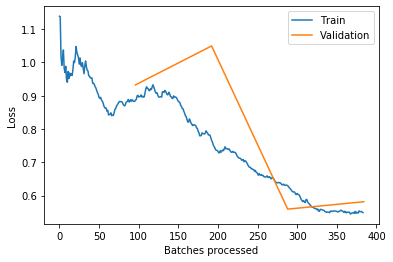

18_224_lr_0.03_cyc_4_i6


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.859694,2.263875,0.572072,0.427928,00:31
1,0.779082,0.709600,0.315315,0.684685,00:31
2,0.637776,0.508467,0.184685,0.815315,00:31
3,0.544242,0.674497,0.229730,0.770270,00:32


Better model found at epoch 0 with accuracy value: 0.4279279410839081.
Better model found at epoch 1 with accuracy value: 0.684684693813324.
Better model found at epoch 2 with accuracy value: 0.815315306186676.


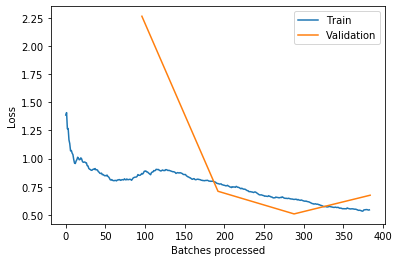

18_224_lr_0.03_cyc_4_i7


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.909571,1.639027,0.621622,0.378378,00:31
1,0.810462,0.755973,0.274775,0.725225,00:31
2,0.634561,0.784355,0.306306,0.693694,00:31
3,0.532980,0.821600,0.283784,0.716216,00:31


Better model found at epoch 0 with accuracy value: 0.37837839126586914.
Better model found at epoch 1 with accuracy value: 0.7252252101898193.


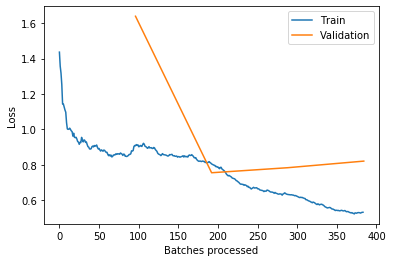

18_224_lr_0.03_cyc_4_i8


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.960416,1.809450,0.545045,0.454955,00:31
1,0.770002,0.617003,0.247748,0.752252,00:31
2,0.650219,0.509748,0.166667,0.833333,00:31
3,0.560140,0.565083,0.157658,0.842342,00:31


Better model found at epoch 0 with accuracy value: 0.45495495200157166.
Better model found at epoch 1 with accuracy value: 0.7522522807121277.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.


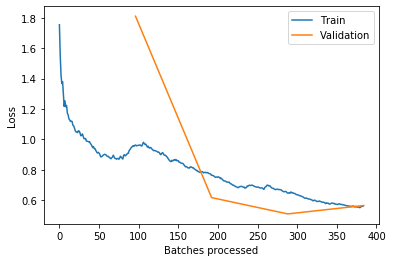

18_224_lr_0.03_cyc_4_i9


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.875271,0.884025,0.432432,0.567568,00:31
1,0.780823,0.843555,0.382883,0.617117,00:32
2,0.635655,0.822552,0.247748,0.752252,00:31
3,0.551409,0.670126,0.207207,0.792793,00:31


Better model found at epoch 0 with accuracy value: 0.5675675868988037.
Better model found at epoch 1 with accuracy value: 0.6171170473098755.
Better model found at epoch 2 with accuracy value: 0.7522522807121277.
Better model found at epoch 3 with accuracy value: 0.792792797088623.


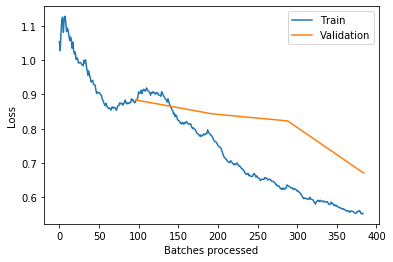

saved stats to: stats\18_224_stats.p


In [64]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [65]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.171   Loss -- best: 0.434  med: 0.583

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.01_cyc_12_i6  error_rate: 0.131   accuracy: 0.869   loss:0.4910
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_12_i8  error_rate: 0.135   accuracy: 0.865   loss:0.4713
18_224_lr_0.01_cyc_12_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4367
18_224_lr_0.02_cyc_8_i4  error_rate: 0.135   accuracy: 0.865   loss:0.4901
18_224_lr_0.03_cyc_4_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4907
18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.140   accuracy: 0.860   loss:0.5082
18_224_lr_0.03_cyc_8_i1  error_rate: 0.140   accuracy: 0.860   loss:0.4785
18_224_lr_0.03_cyc_8_i3  error_rate: 0.140   accuracy: 0.860   loss:0.4866


18_224_lr_0.02_cyc_8_i0_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.974021,0.689014,0.288288,0.711712,00:32
1,0.906195,0.783353,0.283784,0.716216,00:32
2,0.857843,0.580483,0.189189,0.810811,00:32
3,0.800407,0.738789,0.274775,0.725225,00:31
4,0.754577,0.589695,0.180180,0.819820,00:31
5,0.741140,0.450331,0.130631,0.869369,00:31
6,0.713431,0.688433,0.225225,0.774775,00:31
7,0.703399,0.652359,0.175676,0.824324,00:31


Better model found at epoch 0 with accuracy value: 0.7117117047309875.
Better model found at epoch 1 with accuracy value: 0.7162162065505981.
Better model found at epoch 2 with accuracy value: 0.8108108043670654.
Better model found at epoch 4 with accuracy value: 0.8198198080062866.
Better model found at epoch 5 with accuracy value: 0.869369387626648.


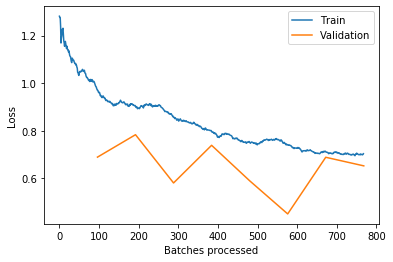

18_224_lr_0.02_cyc_8_i1_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.978436,0.612080,0.216216,0.783784,00:31
1,0.925048,0.733191,0.360360,0.639640,00:32
2,0.857491,0.756050,0.288288,0.711712,00:31
3,0.790271,0.731174,0.274775,0.725225,00:31
4,0.756060,0.617980,0.216216,0.783784,00:32
5,0.737274,0.542224,0.162162,0.837838,00:31
6,0.708196,0.528058,0.157658,0.842342,00:31
7,0.694267,0.527997,0.148649,0.851351,00:31


Better model found at epoch 0 with accuracy value: 0.7837837934494019.
Better model found at epoch 5 with accuracy value: 0.837837815284729.
Better model found at epoch 6 with accuracy value: 0.8423423171043396.
Better model found at epoch 7 with accuracy value: 0.8513513803482056.


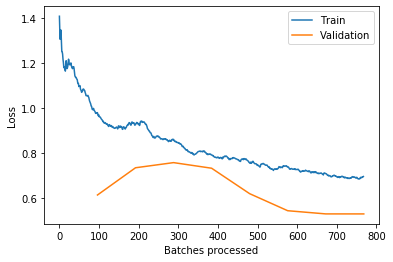

18_224_lr_0.02_cyc_8_i2_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.920117,0.655196,0.252252,0.747748,00:31
1,0.912644,0.816374,0.423423,0.576577,00:31
2,0.820576,0.588062,0.193694,0.806306,00:31
3,0.783129,0.912299,0.351351,0.648649,00:31
4,0.756374,0.805046,0.265766,0.734234,00:32
5,0.709455,0.705079,0.225225,0.774775,00:32
6,0.686396,0.614294,0.198198,0.801802,00:32
7,0.681932,0.567441,0.162162,0.837838,00:31


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 2 with accuracy value: 0.8063063025474548.
Better model found at epoch 7 with accuracy value: 0.837837815284729.


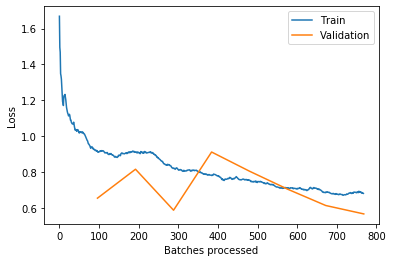

18_224_lr_0.02_cyc_8_i3_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.981318,0.660828,0.265766,0.734234,00:31
1,0.945357,0.678886,0.279279,0.720721,00:31
2,0.882290,0.722749,0.189189,0.810811,00:31
3,0.838740,0.606741,0.225225,0.774775,00:31
4,0.757170,0.592713,0.153153,0.846847,00:31
5,0.741952,0.594579,0.166667,0.833333,00:31
6,0.703473,0.575641,0.153153,0.846847,00:31
7,0.712653,0.565723,0.148649,0.851351,00:31


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 2 with accuracy value: 0.8108108043670654.
Better model found at epoch 4 with accuracy value: 0.8468468189239502.
Better model found at epoch 7 with accuracy value: 0.8513513803482056.


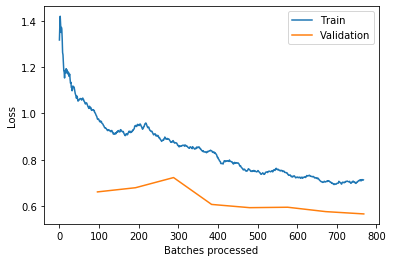

18_224_lr_0.02_cyc_8_i4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.958437,0.796150,0.292793,0.707207,00:31
1,0.897024,1.653636,0.644144,0.355856,00:31
2,0.847815,0.594580,0.171171,0.828829,00:32
3,0.788940,0.570100,0.166667,0.833333,00:31
4,0.744561,0.649673,0.252252,0.747748,00:30
5,0.727615,0.608279,0.202703,0.797297,00:30
6,0.698867,0.634285,0.184685,0.815315,00:32
7,0.674566,0.635007,0.175676,0.824324,00:31


Better model found at epoch 0 with accuracy value: 0.707207202911377.
Better model found at epoch 2 with accuracy value: 0.8288288116455078.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.


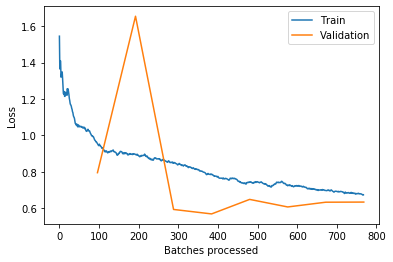

18_224_lr_0.02_cyc_8_i5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.951089,0.615360,0.211712,0.788288,00:32
1,0.894152,0.638588,0.265766,0.734234,00:31
2,0.828445,0.597352,0.243243,0.756757,00:31
3,0.778192,0.709632,0.319820,0.680180,00:32
4,0.760201,0.565255,0.175676,0.824324,00:31
5,0.718416,0.805678,0.279279,0.720721,00:31
6,0.682400,0.649447,0.225225,0.774775,00:31
7,0.670119,0.706439,0.238739,0.761261,00:31


Better model found at epoch 0 with accuracy value: 0.7882882952690125.
Better model found at epoch 4 with accuracy value: 0.8243243098258972.


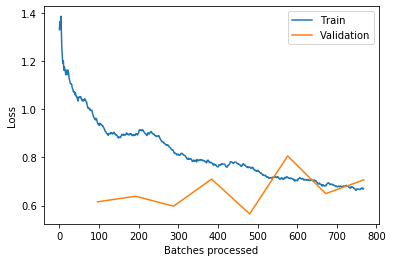

18_224_lr_0.02_cyc_8_i6_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.002048,0.812709,0.346847,0.653153,00:31
1,0.921466,1.013959,0.432432,0.567568,00:31
2,0.867780,0.563572,0.166667,0.833333,00:31
3,0.794813,0.557240,0.166667,0.833333,00:31
4,0.761001,0.564173,0.225225,0.774775,00:31
5,0.732536,0.517047,0.166667,0.833333,00:31
6,0.712103,0.632631,0.171171,0.828829,00:31
7,0.696561,0.555920,0.166667,0.833333,00:31


Better model found at epoch 0 with accuracy value: 0.6531531810760498.
Better model found at epoch 2 with accuracy value: 0.8333333134651184.


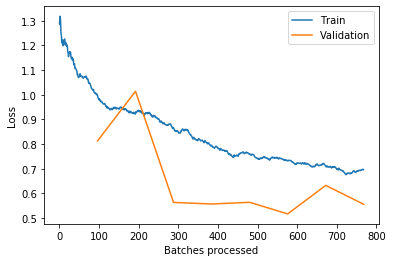

18_224_lr_0.02_cyc_8_i7_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.970006,0.709996,0.283784,0.716216,00:31
1,0.931675,1.061718,0.490991,0.509009,00:31
2,0.848212,0.748241,0.283784,0.716216,00:30
3,0.773186,0.990478,0.346847,0.653153,00:32
4,0.754548,0.731553,0.243243,0.756757,00:31
5,0.741450,0.594620,0.193694,0.806306,00:31
6,0.701691,0.495952,0.126126,0.873874,00:31
7,0.682238,0.518321,0.130631,0.869369,00:30


Better model found at epoch 0 with accuracy value: 0.7162162065505981.
Better model found at epoch 4 with accuracy value: 0.7567567825317383.
Better model found at epoch 5 with accuracy value: 0.8063063025474548.
Better model found at epoch 6 with accuracy value: 0.8738738894462585.


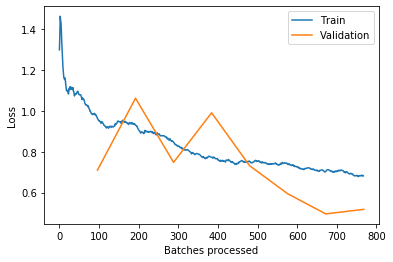

18_224_lr_0.02_cyc_8_i8_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.983122,0.660438,0.252252,0.747748,00:31
1,0.904439,1.140275,0.432432,0.567568,00:31
2,0.866822,0.636471,0.328829,0.671171,00:32
3,0.794279,0.574224,0.189189,0.810811,00:31
4,0.768201,0.641791,0.148649,0.851351,00:31
5,0.723715,0.489757,0.148649,0.851351,00:31
6,0.699132,0.596543,0.171171,0.828829,00:31
7,0.675530,0.607420,0.180180,0.819820,00:31


Better model found at epoch 0 with accuracy value: 0.7477477192878723.
Better model found at epoch 3 with accuracy value: 0.8108108043670654.
Better model found at epoch 4 with accuracy value: 0.8513513803482056.


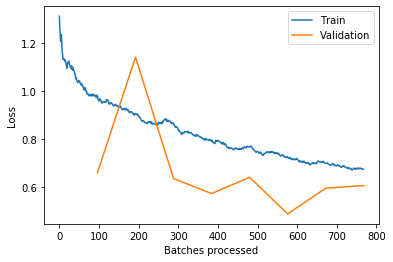

18_224_lr_0.02_cyc_8_i9_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.952745,0.870825,0.319820,0.680180,00:31
1,0.908915,0.920732,0.436937,0.563063,00:31
2,0.850562,0.713780,0.351351,0.648649,00:31
3,0.792827,0.579589,0.198198,0.801802,00:31
4,0.764314,0.626089,0.225225,0.774775,00:31
5,0.730009,0.597344,0.198198,0.801802,00:31
6,0.686038,0.588605,0.198198,0.801802,00:31
7,0.678485,0.598867,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.6801801919937134.
Better model found at epoch 3 with accuracy value: 0.8018018007278442.
Better model found at epoch 7 with accuracy value: 0.8108108043670654.


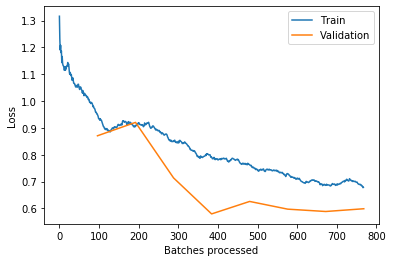

saved stats to: stats\18_224_stats.p


In [66]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [67]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.169   Loss -- best: 0.434  med: 0.581

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.02_cyc_8_i7_m  error_rate: 0.126   accuracy: 0.874   loss:0.4960
18_224_lr_0.01_cyc_12_i6  error_rate: 0.131   accuracy: 0.869   loss:0.4910
18_224_lr_0.02_cyc_8_i0_m  error_rate: 0.131   accuracy: 0.869   loss:0.4503
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_12_i8  error_rate: 0.135   accuracy: 0.865   loss:0.4713
18_224_lr_0.01_cyc_12_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4367
18_224_lr_0.02_cyc_8_i4  error_rate: 0.135   accuracy: 0.865   loss:0.4901
18_224_lr_0.03_cyc_4_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4907
18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.140   accuracy: 0.860   loss:0.5082


18_224_lr_0.02_cyc_16_i0_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.984725,0.603512,0.207207,0.792793,00:31
1,0.876098,0.652365,0.252252,0.747748,00:31
2,0.866136,0.587465,0.216216,0.783784,00:31
3,0.838322,0.527983,0.171171,0.828829,00:31
4,0.781276,0.701443,0.265766,0.734234,00:32
5,0.785850,0.553943,0.193694,0.806306,00:31
6,0.782514,0.661701,0.306306,0.693694,00:32
7,0.762908,0.638850,0.301802,0.698198,00:32
8,0.747623,0.647578,0.229730,0.770270,00:31
9,0.734396,0.629961,0.216216,0.783784,00:31


Better model found at epoch 0 with accuracy value: 0.792792797088623.
Better model found at epoch 3 with accuracy value: 0.8288288116455078.
Better model found at epoch 11 with accuracy value: 0.8333333134651184.
Better model found at epoch 14 with accuracy value: 0.837837815284729.


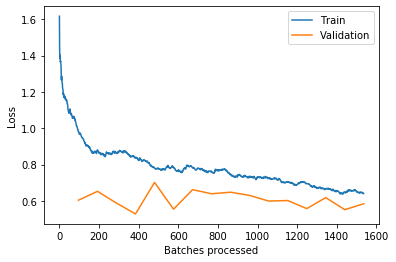

18_224_lr_0.02_cyc_16_i1_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.960191,0.682866,0.229730,0.770270,00:31
1,0.858728,0.676470,0.229730,0.770270,00:30
2,0.856582,0.653318,0.256757,0.743243,00:31
3,0.828648,0.927692,0.396396,0.603604,00:30
4,0.818951,1.163420,0.567568,0.432432,00:32
5,0.794055,0.857825,0.400901,0.599099,00:31
6,0.771089,0.745672,0.297297,0.702703,00:31
7,0.760104,0.541609,0.184685,0.815315,00:32
8,0.755183,0.561277,0.207207,0.792793,00:31
9,0.737800,0.804839,0.292793,0.707207,00:31


Better model found at epoch 0 with accuracy value: 0.7702702879905701.
Better model found at epoch 7 with accuracy value: 0.815315306186676.
Better model found at epoch 11 with accuracy value: 0.837837815284729.


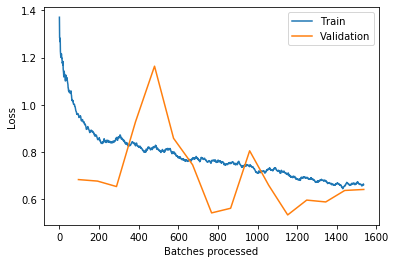

18_224_lr_0.02_cyc_16_i2_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.998201,0.653900,0.225225,0.774775,00:31
1,0.863178,0.840849,0.288288,0.711712,00:31
2,0.862881,0.676957,0.234234,0.765766,00:31
3,0.828181,0.718995,0.184685,0.815315,00:31
4,0.803364,0.551501,0.153153,0.846847,00:30
5,0.791959,0.628393,0.202703,0.797297,00:31
6,0.772114,1.159645,0.436937,0.563063,00:31
7,0.788070,1.073920,0.545045,0.454955,00:31
8,0.752014,0.794057,0.301802,0.698198,00:31
9,0.756039,0.581083,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.7747747898101807.
Better model found at epoch 3 with accuracy value: 0.815315306186676.
Better model found at epoch 4 with accuracy value: 0.8468468189239502.
Better model found at epoch 10 with accuracy value: 0.8738738894462585.


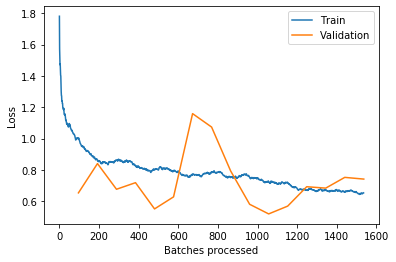

18_224_lr_0.02_cyc_16_i3_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.016842,0.645870,0.216216,0.783784,00:31
1,0.856083,0.753469,0.288288,0.711712,00:32
2,0.862211,0.629125,0.247748,0.752252,00:31
3,0.837858,0.852802,0.360360,0.639640,00:31
4,0.823907,0.925876,0.337838,0.662162,00:31
5,0.776412,1.213285,0.522523,0.477477,00:31
6,0.775018,0.606816,0.261261,0.738739,00:31
7,0.783856,0.562278,0.139640,0.860360,00:33
8,0.756602,0.639162,0.225225,0.774775,00:32
9,0.730355,0.536429,0.144144,0.855856,00:32


Better model found at epoch 0 with accuracy value: 0.7837837934494019.
Better model found at epoch 7 with accuracy value: 0.8603603839874268.


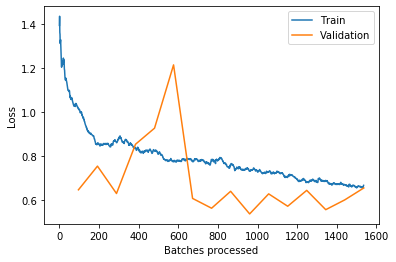

18_224_lr_0.02_cyc_16_i4_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.957290,0.642266,0.220721,0.779279,00:32
1,0.846837,0.496613,0.148649,0.851351,00:31
2,0.845852,1.085337,0.436937,0.563063,00:31
3,0.822973,0.875095,0.414414,0.585586,00:32
4,0.786936,0.539657,0.189189,0.810811,00:31
5,0.793781,0.753120,0.373874,0.626126,00:31
6,0.765433,0.502121,0.180180,0.819820,00:31
7,0.776539,0.585487,0.144144,0.855856,00:31
8,0.750358,0.575042,0.148649,0.851351,00:31
9,0.736889,0.910878,0.391892,0.608108,00:31


Better model found at epoch 0 with accuracy value: 0.7792792916297913.
Better model found at epoch 1 with accuracy value: 0.8513513803482056.
Better model found at epoch 7 with accuracy value: 0.8558558821678162.


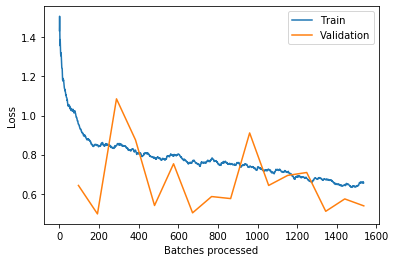

18_224_lr_0.02_cyc_16_i5_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.972262,0.738545,0.310811,0.689189,00:31
1,0.842333,0.640738,0.216216,0.783784,00:31
2,0.867131,0.704142,0.270270,0.729730,00:31
3,0.842016,0.810669,0.315315,0.684685,00:31
4,0.819716,1.136385,0.463964,0.536036,00:31
5,0.782144,0.589167,0.175676,0.824324,00:31
6,0.788811,0.784003,0.333333,0.666667,00:32
7,0.778603,0.546334,0.175676,0.824324,00:31
8,0.753404,0.784648,0.283784,0.716216,00:31
9,0.745237,0.593247,0.171171,0.828829,00:31


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 1 with accuracy value: 0.7837837934494019.
Better model found at epoch 5 with accuracy value: 0.8243243098258972.
Better model found at epoch 9 with accuracy value: 0.8288288116455078.
Better model found at epoch 10 with accuracy value: 0.8468468189239502.


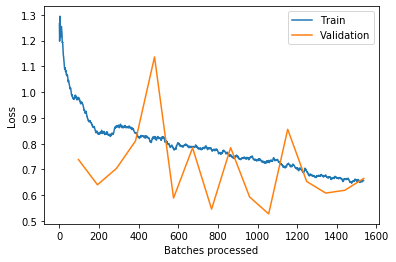

18_224_lr_0.02_cyc_16_i6_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.018409,0.580077,0.202703,0.797297,00:31
1,0.873074,0.553993,0.189189,0.810811,00:31
2,0.843438,0.768777,0.319820,0.680180,00:31
3,0.817086,0.931343,0.382883,0.617117,00:30
4,0.796178,0.685734,0.252252,0.747748,00:31
5,0.795964,0.740741,0.310811,0.689189,00:31
6,0.773385,0.698253,0.238739,0.761261,00:30
7,0.764777,0.533005,0.171171,0.828829,00:31
8,0.775512,0.674456,0.261261,0.738739,00:31
9,0.749097,0.733096,0.274775,0.725225,00:31


Better model found at epoch 0 with accuracy value: 0.7972972989082336.
Better model found at epoch 1 with accuracy value: 0.8108108043670654.
Better model found at epoch 7 with accuracy value: 0.8288288116455078.


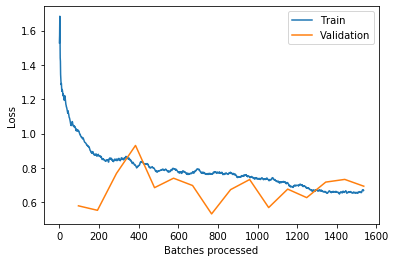

18_224_lr_0.02_cyc_16_i7_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.980930,0.602913,0.202703,0.797297,00:31
1,0.861530,0.724217,0.238739,0.761261,00:31
2,0.844495,0.659717,0.207207,0.792793,00:31
3,0.830923,0.881910,0.315315,0.684685,00:31
4,0.803118,1.146157,0.436937,0.563063,00:31
5,0.794548,0.670724,0.216216,0.783784,00:31
6,0.788302,0.593082,0.220721,0.779279,00:32
7,0.771592,0.687216,0.256757,0.743243,00:32
8,0.771739,0.587288,0.216216,0.783784,00:32
9,0.748709,0.621025,0.225225,0.774775,00:32


Better model found at epoch 0 with accuracy value: 0.7972972989082336.
Better model found at epoch 10 with accuracy value: 0.8288288116455078.
Better model found at epoch 12 with accuracy value: 0.8333333134651184.
Better model found at epoch 13 with accuracy value: 0.8423423171043396.


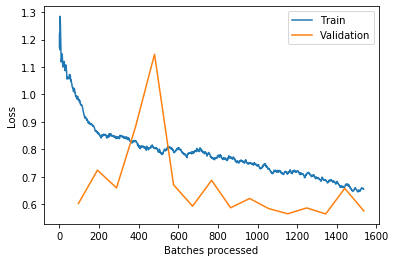

18_224_lr_0.02_cyc_16_i8_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.998329,0.710290,0.265766,0.734234,00:32
1,0.850338,0.661070,0.234234,0.765766,00:31
2,0.862406,0.645094,0.297297,0.702703,00:31
3,0.845583,0.575242,0.261261,0.738739,00:32
4,0.812423,0.680232,0.252252,0.747748,00:31
5,0.778612,0.661401,0.180180,0.819820,00:31
6,0.765971,0.577061,0.189189,0.810811,00:31
7,0.788672,0.772511,0.351351,0.648649,00:32
8,0.778027,0.598522,0.198198,0.801802,00:31
9,0.739147,0.820590,0.333333,0.666667,00:31


Better model found at epoch 0 with accuracy value: 0.7342342138290405.
Better model found at epoch 1 with accuracy value: 0.7657657861709595.
Better model found at epoch 5 with accuracy value: 0.8198198080062866.
Better model found at epoch 12 with accuracy value: 0.8333333134651184.


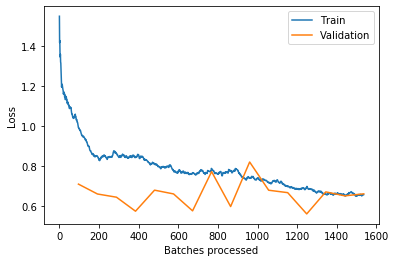

18_224_lr_0.02_cyc_16_i9_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.013678,0.815944,0.310811,0.689189,00:31
1,0.846875,0.572616,0.211712,0.788288,00:32
2,0.871717,0.923725,0.346847,0.653153,00:32
3,0.835473,0.824612,0.346847,0.653153,00:31
4,0.803213,0.499373,0.157658,0.842342,00:30
5,0.780044,0.756560,0.333333,0.666667,00:31
6,0.774450,0.726250,0.315315,0.684685,00:31
7,0.767399,0.682396,0.243243,0.756757,00:31
8,0.733109,0.505533,0.157658,0.842342,00:30
9,0.738803,0.741776,0.355856,0.644144,00:31


Better model found at epoch 0 with accuracy value: 0.6891891956329346.
Better model found at epoch 1 with accuracy value: 0.7882882952690125.
Better model found at epoch 4 with accuracy value: 0.8423423171043396.


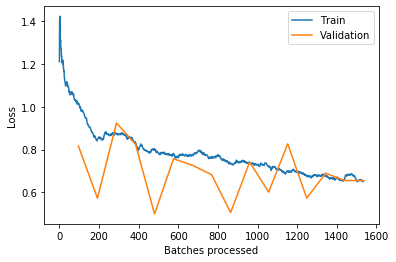

saved stats to: stats\18_224_stats.p


In [68]:
for i in range(10):
    for key, params in get_params(all_cycles=[16], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [69]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.167   Loss -- best: 0.434  med: 0.576

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.02_cyc_16_i2_m  error_rate: 0.126   accuracy: 0.874   loss:0.5196
18_224_lr_0.02_cyc_8_i7_m  error_rate: 0.126   accuracy: 0.874   loss:0.4960
18_224_lr_0.01_cyc_12_i6  error_rate: 0.131   accuracy: 0.869   loss:0.4910
18_224_lr_0.02_cyc_8_i0_m  error_rate: 0.131   accuracy: 0.869   loss:0.4503
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_12_i8  error_rate: 0.135   accuracy: 0.865   loss:0.4713
18_224_lr_0.01_cyc_12_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4367
18_224_lr_0.02_cyc_8_i4  error_rate: 0.135   accuracy: 0.865   loss:0.4901
18_224_lr_0.03_cyc_4_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4907


18_224_lr_0.03_cyc_8_i0_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.437472,0.906216,0.288288,0.711712,00:30
1,1.206424,1.339721,0.414414,0.585586,00:30
2,0.885602,0.921530,0.418919,0.581081,00:31
3,0.814297,1.178282,0.531532,0.468468,00:31
4,0.767544,0.651076,0.220721,0.779279,00:31
5,0.743224,0.608635,0.180180,0.819820,00:30
6,0.731061,0.594275,0.171171,0.828829,00:31
7,0.681093,0.601855,0.171171,0.828829,00:30


Better model found at epoch 0 with accuracy value: 0.7117117047309875.
Better model found at epoch 4 with accuracy value: 0.7792792916297913.
Better model found at epoch 5 with accuracy value: 0.8198198080062866.
Better model found at epoch 6 with accuracy value: 0.8288288116455078.


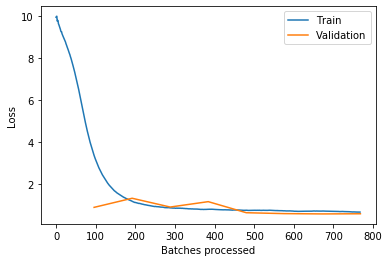

18_224_lr_0.03_cyc_8_i1_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.798451,1.619329,0.459459,0.540541,00:30
1,1.248656,0.721573,0.288288,0.711712,00:31
2,0.871116,1.515766,0.549550,0.450450,00:31
3,0.800987,0.852974,0.292793,0.707207,00:31
4,0.780592,0.953800,0.292793,0.707207,00:31
5,0.766126,0.559363,0.166667,0.833333,00:31
6,0.709581,0.668667,0.211712,0.788288,00:31
7,0.682795,0.636878,0.189189,0.810811,00:31


Better model found at epoch 0 with accuracy value: 0.5405405163764954.
Better model found at epoch 1 with accuracy value: 0.7117117047309875.
Better model found at epoch 5 with accuracy value: 0.8333333134651184.


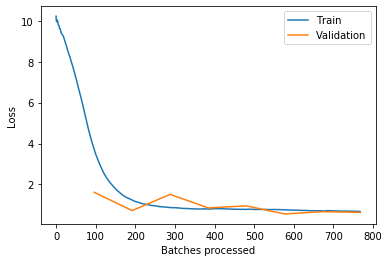

18_224_lr_0.03_cyc_8_i2_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.795398,1.378362,0.328829,0.671171,00:30
1,1.283830,0.774828,0.270270,0.729730,00:30
2,0.895726,0.705565,0.292793,0.707207,00:31
3,0.810199,0.553545,0.157658,0.842342,00:31
4,0.771125,0.579377,0.148649,0.851351,00:30
5,0.762453,0.471329,0.139640,0.860360,00:31
6,0.720898,0.542333,0.171171,0.828829,00:31
7,0.702259,0.521993,0.162162,0.837838,00:31


Better model found at epoch 0 with accuracy value: 0.6711711883544922.
Better model found at epoch 1 with accuracy value: 0.7297297120094299.
Better model found at epoch 3 with accuracy value: 0.8423423171043396.
Better model found at epoch 4 with accuracy value: 0.8513513803482056.
Better model found at epoch 5 with accuracy value: 0.8603603839874268.


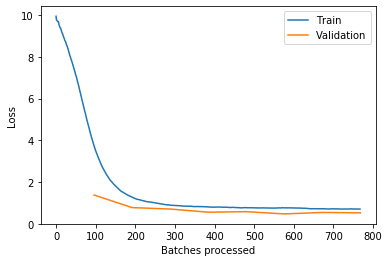

18_224_lr_0.03_cyc_8_i3_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.513943,1.750016,0.490991,0.509009,00:30
1,1.197375,0.919084,0.306306,0.693694,00:30
2,0.893663,0.659541,0.288288,0.711712,00:30
3,0.813084,1.008525,0.409910,0.590090,00:30
4,0.767665,0.580882,0.184685,0.815315,00:30
5,0.741302,0.487771,0.148649,0.851351,00:30
6,0.697267,0.630158,0.189189,0.810811,00:30
7,0.687516,0.577152,0.175676,0.824324,00:30


Better model found at epoch 0 with accuracy value: 0.5090090036392212.
Better model found at epoch 1 with accuracy value: 0.6936936974525452.
Better model found at epoch 2 with accuracy value: 0.7117117047309875.
Better model found at epoch 4 with accuracy value: 0.815315306186676.
Better model found at epoch 5 with accuracy value: 0.8513513803482056.


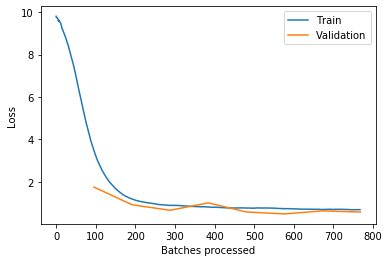

18_224_lr_0.03_cyc_8_i4_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.465098,1.508347,0.387387,0.612613,00:31
1,1.227721,0.892583,0.346847,0.653153,00:30
2,0.887357,0.778893,0.270270,0.729730,00:30
3,0.805975,0.503622,0.171171,0.828829,00:30
4,0.778742,0.530271,0.148649,0.851351,00:31
5,0.736125,0.600592,0.261261,0.738739,00:31
6,0.722203,0.578756,0.171171,0.828829,00:30
7,0.696152,0.584553,0.175676,0.824324,00:30


Better model found at epoch 0 with accuracy value: 0.6126126050949097.
Better model found at epoch 1 with accuracy value: 0.6531531810760498.
Better model found at epoch 2 with accuracy value: 0.7297297120094299.
Better model found at epoch 3 with accuracy value: 0.8288288116455078.
Better model found at epoch 4 with accuracy value: 0.8513513803482056.


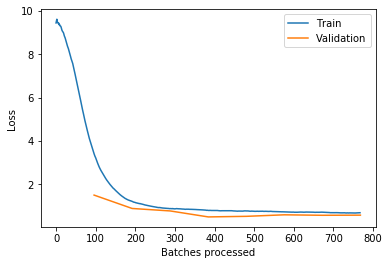

18_224_lr_0.03_cyc_8_i5_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.757452,1.987126,0.576577,0.423423,00:30
1,1.279000,0.873547,0.315315,0.684685,00:31
2,0.871288,0.599394,0.252252,0.747748,00:30
3,0.809725,1.538446,0.441441,0.558559,00:30
4,0.783255,0.575575,0.139640,0.860360,00:30
5,0.736374,0.734018,0.270270,0.729730,00:30
6,0.707635,0.675789,0.166667,0.833333,00:30
7,0.693162,0.591656,0.148649,0.851351,00:31


Better model found at epoch 0 with accuracy value: 0.4234234094619751.
Better model found at epoch 1 with accuracy value: 0.6846846342086792.
Better model found at epoch 2 with accuracy value: 0.7477477192878723.
Better model found at epoch 4 with accuracy value: 0.8603603839874268.


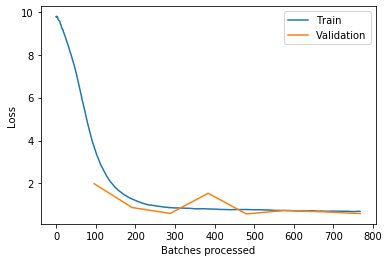

18_224_lr_0.03_cyc_8_i6_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.853163,1.498117,0.481982,0.518018,00:30
1,1.260269,0.754341,0.229730,0.770270,00:30
2,0.880820,0.623968,0.229730,0.770270,00:31
3,0.820916,0.550283,0.166667,0.833333,00:30
4,0.790042,0.678267,0.211712,0.788288,00:31
5,0.743441,0.465108,0.144144,0.855856,00:30
6,0.730244,0.508880,0.148649,0.851351,00:31
7,0.690150,0.552613,0.175676,0.824324,00:31


Better model found at epoch 0 with accuracy value: 0.5180180072784424.
Better model found at epoch 1 with accuracy value: 0.7702702879905701.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.
Better model found at epoch 5 with accuracy value: 0.8558558821678162.


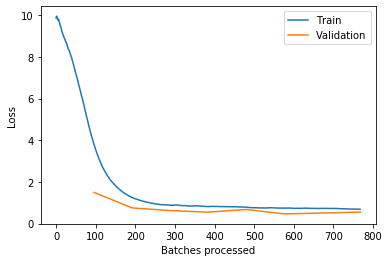

18_224_lr_0.03_cyc_8_i7_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.796407,1.557426,0.405405,0.594595,00:31
1,1.304735,0.750562,0.288288,0.711712,00:30
2,0.934041,0.769930,0.261261,0.738739,00:30
3,0.819055,0.623339,0.211712,0.788288,00:31
4,0.787805,0.511055,0.166667,0.833333,00:30
5,0.759039,0.613248,0.211712,0.788288,00:31
6,0.728827,0.585102,0.171171,0.828829,00:31
7,0.689978,0.585892,0.171171,0.828829,00:31


Better model found at epoch 0 with accuracy value: 0.5945945978164673.
Better model found at epoch 1 with accuracy value: 0.7117117047309875.
Better model found at epoch 2 with accuracy value: 0.7387387156486511.
Better model found at epoch 3 with accuracy value: 0.7882882952690125.
Better model found at epoch 4 with accuracy value: 0.8333333134651184.


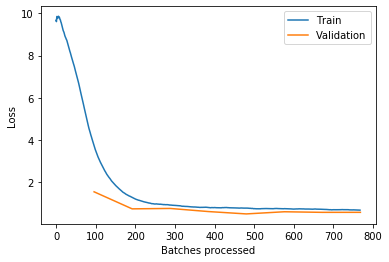

18_224_lr_0.03_cyc_8_i8_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.877249,1.416086,0.418919,0.581081,00:31
1,1.274735,0.800610,0.387387,0.612613,00:30
2,0.874133,0.552241,0.216216,0.783784,00:30
3,0.842079,0.529832,0.198198,0.801802,00:31
4,0.767976,0.769669,0.265766,0.734234,00:31
5,0.728911,0.593390,0.180180,0.819820,00:31
6,0.706680,0.545135,0.157658,0.842342,00:30
7,0.700668,0.573779,0.162162,0.837838,00:30


Better model found at epoch 0 with accuracy value: 0.5810810923576355.
Better model found at epoch 1 with accuracy value: 0.6126126050949097.
Better model found at epoch 2 with accuracy value: 0.7837837934494019.
Better model found at epoch 3 with accuracy value: 0.8018018007278442.
Better model found at epoch 5 with accuracy value: 0.8198198080062866.
Better model found at epoch 6 with accuracy value: 0.8423423171043396.


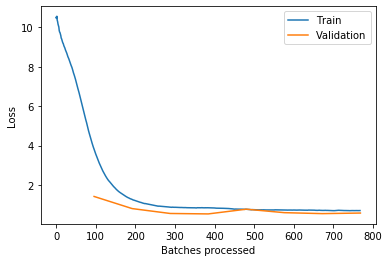

18_224_lr_0.03_cyc_8_i9_ps_None_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.975501,1.097104,0.351351,0.648649,00:31
1,1.298249,0.780293,0.319820,0.680180,00:30
2,0.915071,0.595600,0.175676,0.824324,00:31
3,0.828139,1.313328,0.486486,0.513514,00:30
4,0.804698,0.847640,0.382883,0.617117,00:30
5,0.754228,0.478339,0.139640,0.860360,00:30
6,0.726120,0.512338,0.148649,0.851351,00:30
7,0.703938,0.583303,0.175676,0.824324,00:30


Better model found at epoch 0 with accuracy value: 0.6486486196517944.
Better model found at epoch 1 with accuracy value: 0.6801801919937134.
Better model found at epoch 2 with accuracy value: 0.8243243098258972.
Better model found at epoch 5 with accuracy value: 0.8603603839874268.


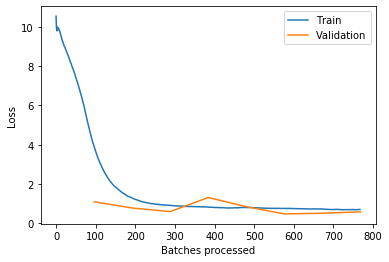

saved stats to: stats\18_224_stats.p


In [70]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [71]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.167   Loss -- best: 0.434  med: 0.572

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.02_cyc_16_i2_m  error_rate: 0.126   accuracy: 0.874   loss:0.5196
18_224_lr_0.02_cyc_8_i7_m  error_rate: 0.126   accuracy: 0.874   loss:0.4960
18_224_lr_0.01_cyc_12_i6  error_rate: 0.131   accuracy: 0.869   loss:0.4910
18_224_lr_0.02_cyc_8_i0_m  error_rate: 0.131   accuracy: 0.869   loss:0.4503
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_12_i8  error_rate: 0.135   accuracy: 0.865   loss:0.4713
18_224_lr_0.01_cyc_12_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4367
18_224_lr_0.02_cyc_8_i4  error_rate: 0.135   accuracy: 0.865   loss:0.4901
18_224_lr_0.03_cyc_4_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4907


In [ ]:
for key, params in get_params(all_cycles=[16], all_lr=[1e-3, 3e-4, 1e-4]):
    for ps in [0.5, 0.8, 0.85, 0.9]:
        do_train(key, mixup=True, ps=ps, **params)
all_stats.save()

18_224_lr_0.001_cyc_16_m


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.192323,0.725782,0.274775,0.725225,00:31


Better model found at epoch 0 with accuracy value: 0.7252252101898193.


In [ ]:
show_results(all_stats.get(), limit=10)

## Summary of Results

In [23]:
for key in [None, 'lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12',  'cyc_16', 
            '_m', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, show_details=False)

Overall         Error -- best: 0.122  med: 0.167   Loss -- best: 0.434  med: 0.572
lr_0.03         Error -- best: 0.135  med: 0.167   Loss -- best: 0.465  med: 0.562
lr_0.02         Error -- best: 0.126  med: 0.162   Loss -- best: 0.450  med: 0.563
lr_0.01         Error -- best: 0.122  med: 0.171   Loss -- best: 0.434  med: 0.564
lr_0.003        Error -- best: 0.158  med: 0.196   Loss -- best: 0.469  med: 0.618
lr_0.001        Error -- best: 0.135  med: 0.162   Loss -- best: 0.508  med: 0.559
lr_0.0003       Error -- best: 0.149  med: 0.176   Loss -- best: 0.521  med: 0.596
lr_0.0001       Error -- best: 0.162  med: 0.198   Loss -- best: 0.600  med: 0.643
cyc_4           Error -- best: 0.135  med: 0.185   Loss -- best: 0.487  med: 0.592
cyc_8           Error -- best: 0.122  med: 0.158   Loss -- best: 0.450  med: 0.546
cyc_12          Error -- best: 0.131  med: 0.151   Loss -- best: 0.434  med: 0.541
cyc_16          Error -- best: 0.126  med: 0.162   Loss -- best: 0.499  med: 0.562
_m  

In [24]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.122  med: 0.167   Loss -- best: 0.434  med: 0.572

18_224_lr_0.01_cyc_8_i4  error_rate: 0.122   accuracy: 0.878   loss:0.4898
18_224_lr_0.02_cyc_16_i2_m  error_rate: 0.126   accuracy: 0.874   loss:0.5196
18_224_lr_0.02_cyc_8_i7_m  error_rate: 0.126   accuracy: 0.874   loss:0.4960
18_224_lr_0.01_cyc_12_i6  error_rate: 0.131   accuracy: 0.869   loss:0.4910
18_224_lr_0.02_cyc_8_i0_m  error_rate: 0.131   accuracy: 0.869   loss:0.4503
18_224_lr_0.001_cyc_8  error_rate: 0.135   accuracy: 0.865   loss:0.5248
18_224_lr_0.01_cyc_12_i8  error_rate: 0.135   accuracy: 0.865   loss:0.4713
18_224_lr_0.01_cyc_12_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4367
18_224_lr_0.02_cyc_8_i4  error_rate: 0.135   accuracy: 0.865   loss:0.4901
18_224_lr_0.03_cyc_4_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4907


In [25]:
for key in ['lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12', 'cyc_16', 
            '_m', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, limit=6)
    print('\n')

lr_0.03         Error -- best: 0.135  med: 0.167   Loss -- best: 0.465  med: 0.562

18_224_lr_0.03_cyc_4_i1  error_rate: 0.135   accuracy: 0.865   loss:0.4907
18_224_lr_0.03_cyc_8_i1  error_rate: 0.140   accuracy: 0.860   loss:0.4785
18_224_lr_0.03_cyc_8_i3  error_rate: 0.140   accuracy: 0.860   loss:0.4866
18_224_lr_0.03_cyc_8_i2_ps_None_m  error_rate: 0.140   accuracy: 0.860   loss:0.4713
18_224_lr_0.03_cyc_4_i2  error_rate: 0.140   accuracy: 0.860   loss:0.6082
18_224_lr_0.03_cyc_8_i5_ps_None_m  error_rate: 0.140   accuracy: 0.860   loss:0.5756


lr_0.02         Error -- best: 0.126  med: 0.162   Loss -- best: 0.450  med: 0.563

18_224_lr_0.02_cyc_16_i2_m  error_rate: 0.126   accuracy: 0.874   loss:0.5196
18_224_lr_0.02_cyc_8_i7_m  error_rate: 0.126   accuracy: 0.874   loss:0.4960
18_224_lr_0.02_cyc_8_i0_m  error_rate: 0.131   accuracy: 0.869   loss:0.4503
18_224_lr_0.02_cyc_8_i4  error_rate: 0.135   accuracy: 0.865   loss:0.4901
18_224_lr_0.02_cyc_16_i3_m  error_rate: 0.140   accur

In [ ]:
assert False

## Inference

- try composite of 4 learners
- try test-time augmentation

In [23]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
name = top_results[0]
print(name)

18_224_lr_0.01_cyc_8_i4



18_224_lr_0.01_cyc_8_i4 Validation tta=False
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        82%         97%        89%        0.89
normal          97%         84%        99%        0.90
virus           87%         82%        94%        0.85


Overall Accuracy: 87.84%


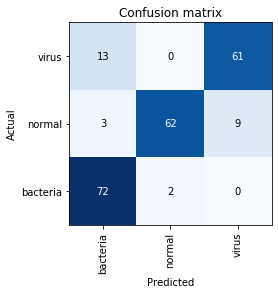

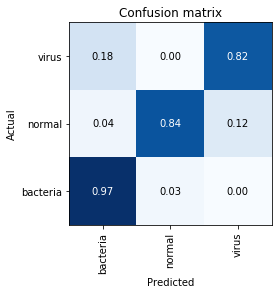

In [24]:
interp = get_interp(name)
print(f'\n{name} Validation tta=False')
analyze_interp(interp)


18_224_lr_0.01_cyc_8_i4 Test tta=False
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        82%         99%        89%        0.90
normal          96%         92%        98%        0.94
virus           90%         76%        96%        0.82


Overall Accuracy: 88.74%


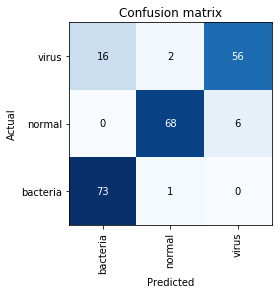

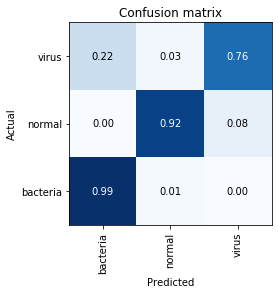

In [25]:
interp = get_interp_test(name)
print(f'\n{name} Test tta=False')
analyze_interp(interp)

#### Use TTA


18_224_lr_0.01_cyc_8_i4 Validation tta=True
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        80%         97%        88%        0.88
normal          97%         81%        99%        0.88
virus           87%         82%        94%        0.85


Overall Accuracy: 86.94%


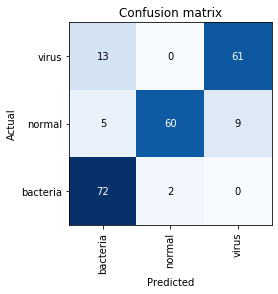

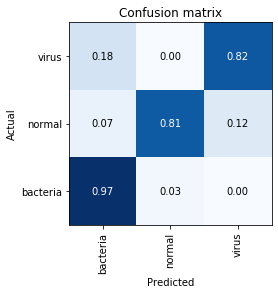

In [26]:
interp = get_interp(name, use_tta=True)
print(f'\n{name} Validation tta=True')
analyze_interp(interp)


18_224_lr_0.01_cyc_8_i4 Test tta=True
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        80%        100%        87%        0.89
normal          97%         92%        99%        0.94
virus           92%         73%        97%        0.81


Overall Accuracy: 88.29%


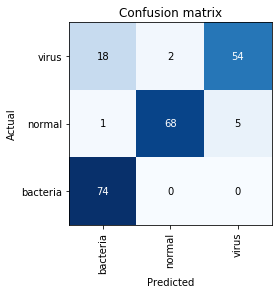

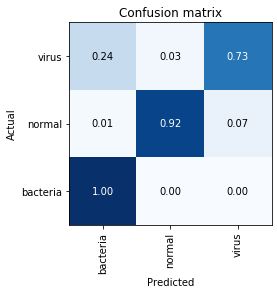

In [27]:
interp = get_interp_test(name, use_tta=True)
print(f'\n{name} Test tta=True')
analyze_interp(interp)

### Composite for Validation based on accuracy

In [28]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

accuracy -- mean: 0.874   median: 0.887   gmean: 0.874   hmean: 0.874


#### Show Individual - for Validation dataset

18_224_lr_0.01_cyc_8_i4
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        82%         97%        89%        0.89
normal          97%         84%        99%        0.90
virus           87%         82%        94%        0.85


Overall Accuracy: 87.84%


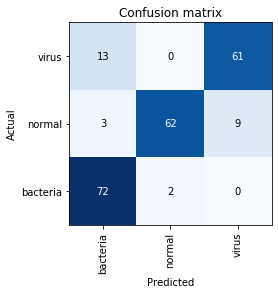

18_224_lr_0.02_cyc_16_i2_m
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        88%         95%        93%        0.91
normal          94%         81%        97%        0.87
virus           82%         86%        91%        0.84


Overall Accuracy: 87.39%


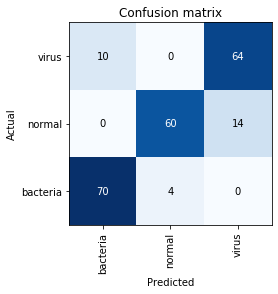

18_224_lr_0.02_cyc_8_i7_m
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        92%         92%        96%        0.92
normal          97%         78%        99%        0.87
virus           77%         92%        86%        0.84


Overall Accuracy: 87.39%


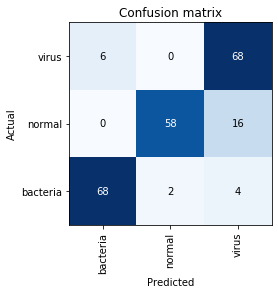

18_224_lr_0.01_cyc_12_i6
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        85%         97%        91%        0.91
normal          97%         78%        99%        0.87
virus           82%         85%        91%        0.83


Overall Accuracy: 86.94%


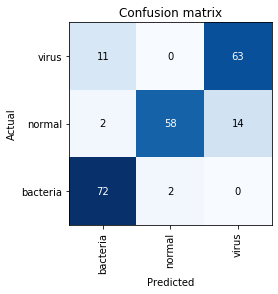

In [29]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

### Composite for Validation based on loss

In [30]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

accuracy -- mean: 0.887   median: 0.887   gmean: 0.892   hmean: 0.892


### Composite for Test based on accuracy

In [31]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.914   median: 0.919   gmean: 0.914   hmean: 0.914


#### Individual results for top 4

18_224_lr_0.01_cyc_8_i4
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        82%         99%        89%        0.90
normal          96%         92%        98%        0.94
virus           90%         76%        96%        0.82


Overall Accuracy: 88.74%


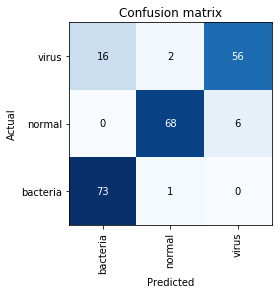

18_224_lr_0.02_cyc_16_i2_m
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        83%         97%        90%        0.89
normal          96%         86%        98%        0.91
virus           85%         78%        93%        0.82


Overall Accuracy: 87.39%


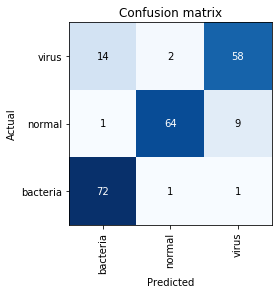

18_224_lr_0.02_cyc_8_i7_m
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        82%         91%        90%        0.86
normal          98%         88%        99%        0.93
virus           81%         81%        91%        0.81


Overall Accuracy: 86.49%


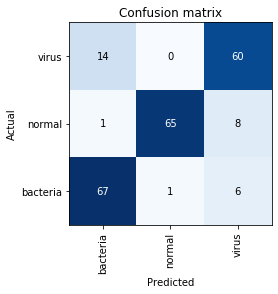

18_224_lr_0.01_cyc_12_i6
            Precision
           Specificity     Recall   Sensitivity    F1
bacteria        81%         97%        89%        0.88
normal          99%         91%        99%        0.94
virus           92%         81%        97%        0.86


Overall Accuracy: 89.64%


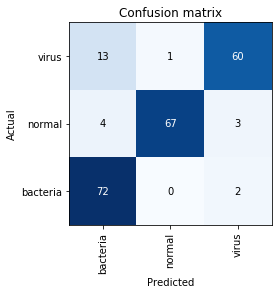

In [32]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

#### Try again using TTA

In [35]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name, use_tta=True)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.896   median: 0.896   gmean: 0.892   hmean: 0.892


### Composite for Test based on loss

In [33]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.910   median: 0.905   gmean: 0.910   hmean: 0.914


#### Try again using TTA

In [36]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name, use_tta=True)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.905   median: 0.901   gmean: 0.905   hmean: 0.905


In [34]:
assert False

AssertionError: 

## Experiment with fine tuning classifier

In [ ]:
name = '18_448cut_lr_0.02_cyc_16_i6_m'

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(2e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-4))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-5))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=2)
stats, new_name

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=8)
stats, new_name

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=8)
    foo.append([1, stats])
foo

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=16)
    foo.append([1, stats])
    print('\n')
foo